<a href="https://colab.research.google.com/github/AnantJainn/QuantumML/blob/main/QuantumML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.6 MB/s eta 0:00:00


Epoch   0 | Average Loss: 0.762121
Epoch  20 | Average Loss: 0.694042
Epoch  40 | Average Loss: 0.605787
Epoch  60 | Average Loss: 0.499178
Epoch  80 | Average Loss: 0.406453
Epoch 100 | Average Loss: 0.343984
Epoch 120 | Average Loss: 0.294238
Epoch 140 | Average Loss: 0.258402
Epoch 160 | Average Loss: 0.231161
Epoch 180 | Average Loss: 0.211336
Epoch 200 | Average Loss: 0.194203
Epoch 220 | Average Loss: 0.180636
Epoch 240 | Average Loss: 0.172900
Epoch 260 | Average Loss: 0.168376
Epoch 280 | Average Loss: 0.165397
Epoch 300 | Average Loss: 0.163336
Epoch 320 | Average Loss: 0.161808
Epoch 340 | Average Loss: 0.160590
Epoch 360 | Average Loss: 0.159543
Epoch 380 | Average Loss: 0.158586
Epoch 400 | Average Loss: 0.157670
Epoch 420 | Average Loss: 0.156771
Epoch 440 | Average Loss: 0.155878
Epoch 460 | Average Loss: 0.154987
Epoch 480 | Average Loss: 0.154098

=== Final Fidelities, Actual vs Predicted States ===
State  0: Fidelity=0.879842
  Actual:    [0.4876+0.2399j 0.4335-0.1531j

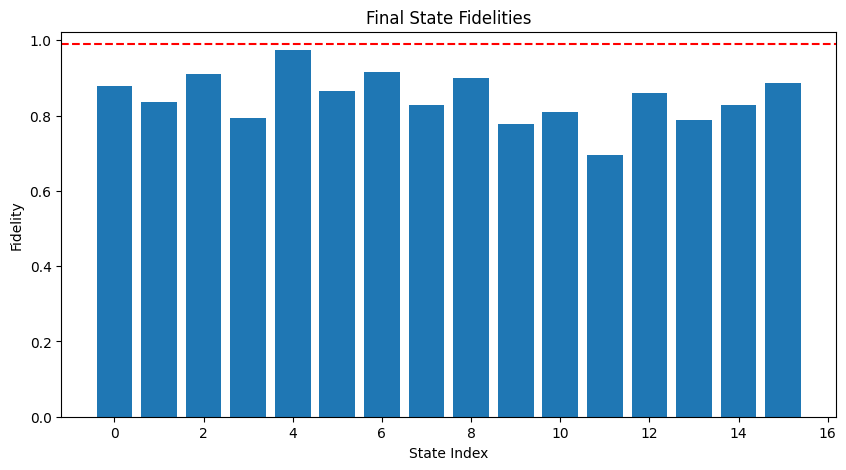

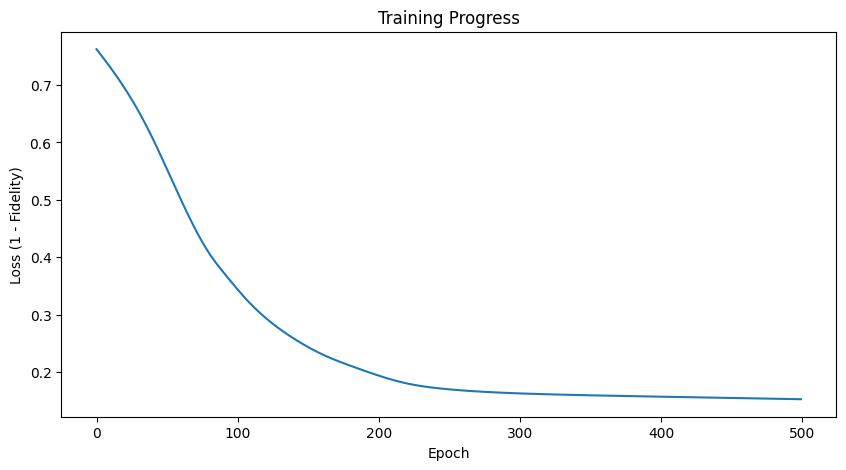

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
import random, math, matplotlib.pyplot as plt

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Simulator and dataset params
NUM_STATES = 16
INPUT_DIM = 4
BATCH_SIZE = NUM_STATES
n_qubits = 2
n_ancilla = math.ceil(math.log2(NUM_STATES))
wires = [f"a{i}" for i in range(n_ancilla)] + [f"q{i}" for i in range(n_qubits)]

def generate_complex_data(num_samples, input_dim):
    X = np.random.randn(num_samples, input_dim)
    # Target states: random complex vectors, normalized
    real_part = np.random.rand(num_samples, 2**n_qubits) + 0.1
    imag_part = np.random.rand(num_samples, 2**n_qubits) - 0.5
    y_complex = real_part + 1j * imag_part
    y_complex = y_complex / np.linalg.norm(y_complex, axis=1, keepdims=True)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y_complex, dtype=torch.complex128)

X, y = generate_complex_data(NUM_STATES, INPUT_DIM)
indices = torch.arange(NUM_STATES, dtype=torch.int64)

dev = qml.device("default.qubit", wires=wires, shots=None)

class QuantumLayer(nn.Module):
    def __init__(self, depth, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn((depth, len(wires))) * 0.1)
    def forward(self):
        return self.theta

def entangling_block(wires):
    for i in range(len(wires)-1):
        qml.CNOT(wires=[wires[i], wires[i+1]])

def layer(theta, layer_idx):
    for i, wire in enumerate(wires):
        qml.RY(theta[layer_idx, i], wires=wire)
    entangling_block(wires)

@qml.qnode(dev, interface="torch", diff_method="best")
def circuit(theta, state_idx=None, input_encoding=None):
    if state_idx is not None:
        binary = format(state_idx, f"0{n_ancilla}b")
        for i, bit in enumerate(binary):
            if bit == "1":
                qml.PauliX(wires=f"a{i}")
    if input_encoding is not None:
        for i in range(min(len(input_encoding), len(wires))):
            qml.RY(input_encoding[i], wires=wires[i])
    for l in range(theta.shape[0]):
        layer(theta, l)
    return qml.state()

def cost(theta):
    total_loss = 0
    for j in range(NUM_STATES):
        state = circuit(theta, state_idx=j, input_encoding=X[j])
        subspace = j
        start = subspace * (2**n_qubits)
        end = start + (2**n_qubits)
        pred = state[start:end]
        pred = pred / torch.linalg.norm(pred)
        target = y[j]
        fid = torch.abs(torch.dot(torch.conj(pred), target))**2
        total_loss += (1 - fid)
    return total_loss / NUM_STATES

def train(initial_depth=8, max_depth=20, lr=0.003, patience_limit=25, max_epochs=500):
    n_layers = initial_depth
    quantum_layer = QuantumLayer(n_layers, wires)
    optimizer = Adam(quantum_layer.parameters(), lr=lr)
    best_loss, patience = float('inf'), 0
    best_theta = None
    losses = []
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        theta = quantum_layer()
        loss = cost(theta)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if loss.item() < best_loss:
            best_loss, patience = loss.item(), 0
            best_theta = quantum_layer.theta.detach().clone()
        else:
            patience += 1
        if patience > patience_limit and n_layers < max_depth:
            print(f"Increasing circuit depth to {n_layers+2} at epoch {epoch}.")
            n_layers += 2
            new_layer = QuantumLayer(n_layers, wires)
            new_layer.theta.data[:best_theta.shape[0], :] = best_theta
            quantum_layer = new_layer
            optimizer = Adam(quantum_layer.parameters(), lr=lr)
            patience = 0
        if patience > patience_limit * 2:
            print(f"Early stopping at epoch {epoch}")
            break
        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Average Loss: {loss.item():.6f}")
    quantum_layer.theta.data = best_theta
    return quantum_layer.theta, losses

def evaluate(theta):
    print('\n=== Final Fidelities, Actual vs Predicted States ===')
    fidelities = []
    pred_states = []
    target_states = []
    for j in range(NUM_STATES):
        state = circuit(theta, state_idx=j, input_encoding=X[j])
        subspace = j
        start = subspace * (2**n_qubits)
        end = start + (2**n_qubits)
        pred = state[start:end]
        pred = pred / torch.linalg.norm(pred)
        target = y[j]
        pred_states.append(pred.detach().numpy())
        target_states.append(target.detach().numpy())
        fid = torch.abs(torch.dot(torch.conj(pred), target))**2
        fidelities.append(fid.item())
        print(f"State {j:2d}: Fidelity={fid.item():.6f}")
        print(f"  Actual:    {np.round(target.detach().numpy(), 4)}")
        print(f"  Predicted: {np.round(pred.detach().numpy(), 4)}")
    print(f"\nAverage Fidelity: {np.mean(fidelities):.6f}")
    print(f"Minimum Fidelity: {np.min(fidelities):.6f}")

    plt.figure(figsize=(10, 5))
    plt.bar(range(NUM_STATES), fidelities)
    plt.axhline(0.99, color="r", linestyle="--")
    plt.xlabel("State Index")
    plt.ylabel("Fidelity")
    plt.title("Final State Fidelities")
    plt.show()

    return fidelities, target_states, pred_states

if __name__ == "__main__":
    theta, losses = train()
    fidelities, actuals, preds = evaluate(theta)
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 - Fidelity)")
    plt.title("Training Progress")
    plt.show()


Number of classes: 7
Class labels: [1 2 3 4 5 6 7]
Using device: default.qubit
epoch    1 | loss 0.804372 | depth 8
epoch   20 | loss 0.700094 | depth 8
epoch   40 | loss 0.570423 | depth 8
epoch   60 | loss 0.424136 | depth 8
epoch   80 | loss 0.309951 | depth 8
epoch  100 | loss 0.261515 | depth 8
epoch  120 | loss 0.231165 | depth 8
epoch  140 | loss 0.204634 | depth 8
epoch  160 | loss 0.179020 | depth 8
epoch  180 | loss 0.152861 | depth 8
epoch  200 | loss 0.124876 | depth 8
epoch  220 | loss 0.096418 | depth 8
epoch  240 | loss 0.071224 | depth 8
epoch  260 | loss 0.051033 | depth 8
epoch  280 | loss 0.034695 | depth 8
epoch  300 | loss 0.021590 | depth 8
epoch  320 | loss 0.012084 | depth 8
epoch  340 | loss 0.006278 | depth 8
epoch  360 | loss 0.003258 | depth 8
epoch  380 | loss 0.001762 | depth 8
epoch  400 | loss 0.000994 | depth 8
epoch  420 | loss 0.000583 | depth 8
epoch  440 | loss 0.000355 | depth 8
epoch  460 | loss 0.000223 | depth 8
epoch  480 | loss 0.000143 | dept

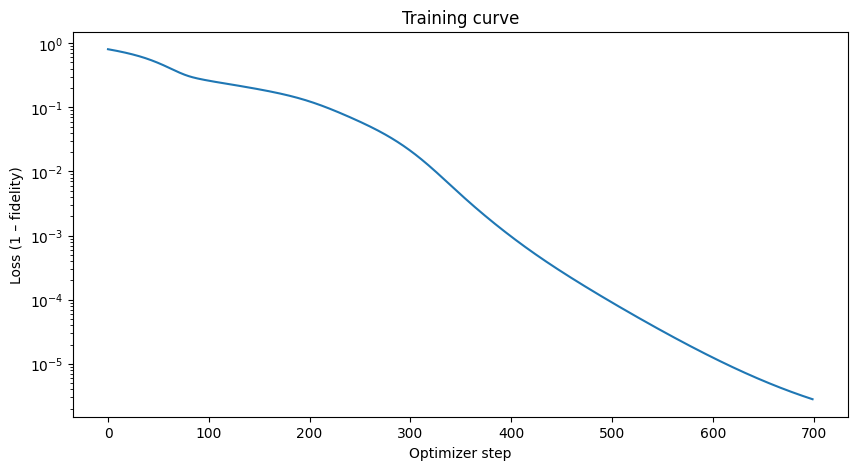


── Per-state fidelities ──
state  0 → 0.999998
state  1 → 0.999991
state  2 → 0.999997
state  3 → 0.999999
state  4 → 0.999998
state  5 → 1.000000
state  6 → 0.999998
─────────────────────────
Average fidelity: 0.999997
Minimum fidelity: 0.999991


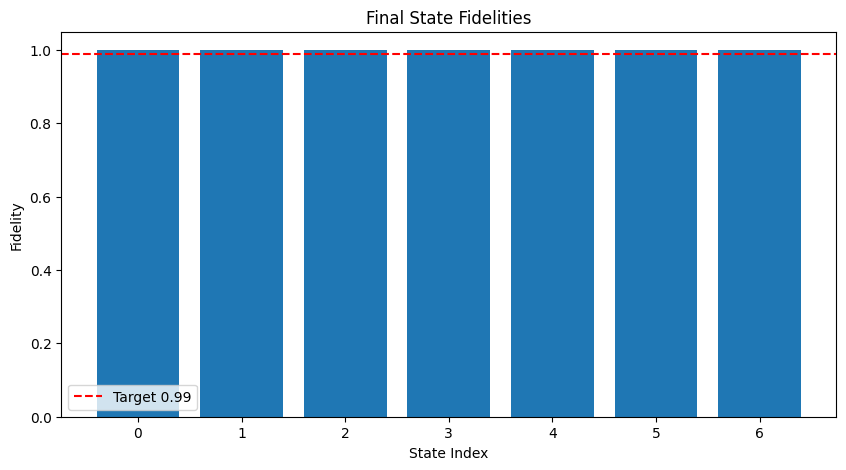

In [ ]:
# Install required packages (run this cell first in Google Colab)
!pip install pennylane pennylane-lightning[gpu] --quiet --upgrade
!pip install torch --quiet --upgrade  # Torch is usually pre-installed, but upgrade for stability
!pip install scikit-learn --quiet --upgrade
"""
Scalable, mini-batch quantum-classical hybrid training loop
────────────────────────────────────────────────────────────
• Lightning GPU/CPU back-end with adjoint differentiation
• Mini-batch DataLoader + broadcastable QNode
• Dynamic circuit-depth growth when the loss plateaus
• AdamW optimiser, ReduceLROnPlateau scheduler & grad-clipping
• Reproducible seeds and deterministic dataloading
• Fixed state_dict loading for dynamic depth
Tested with: PennyLane 0.42+, PyTorch 2.0+
Author: Anant Jain (IIIT-Delhi / QML PhD)
Note: For best performance, switch Colab runtime to GPU (Runtime > Change runtime type > T4 GPU).
"""
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 7               # number of labelled targets
INPUT_DIM          = 4                # length of classical feature-vector
WORK_QUBITS        = 2                # modelling register
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))
WIRES              = [f"a{i}" for i in range(ANCILLA_QUBITS)] + \
                     [f"q{i}" for i in range(WORK_QUBITS)]
BATCH_SIZE         = 8                # mini-batch size
INITIAL_DEPTH      = 8                # parametric layers to start with
MAX_DEPTH          = 8               # hard cap on depth expansion
PATIENCE_STEPS     = 25               # plateau patience before growing depth
LR                 = 3e-3
MAX_EPOCHS         = 700
CLIP_NORM          = 1.0              # gradient-clipping threshold

# ───────────────────────────────────────────────────────────
# 2. DATASET
# ───────────────────────────────────────────────────────────
# def generate_data(n_samples: int, in_dim: int):
#     x = np.random.randn(n_samples, in_dim)
#     y = np.random.rand(n_samples, 2**WORK_QUBITS) + 0.1
#     y = y / np.linalg.norm(y, axis=1, keepdims=True)
#     return (
#         torch.tensor(x, dtype=torch.float32),
#         torch.tensor(y, dtype=torch.complex128)      # complex targets
#     )

# X, Y = generate_data(NUM_STATES, INPUT_DIM)
# state_indices = torch.arange(NUM_STATES, dtype=torch.int64)
# dataset = TensorDataset(X, Y, state_indices)
# loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
#                      shuffle=True, generator=torch.Generator().manual_seed(SEED))


# ───────────────────────────────────────────────────────────
# 2. DATASET (Covertype integration)
# ───────────────────────────────────────────────────────────
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler
import numpy as onp  # Use the original numpy to avoid Pennylane's numpy issues

# Load Covertype data
X_cov, y_cov = fetch_covtype(return_X_y=True)  # X_cov: (581012, 54), y_cov: (581012,)

print("Number of classes:", len(onp.unique(y_cov)))
print("Class labels:", onp.unique(y_cov))


# For demonstration and quantum resource limits, take a small subset and adjust for NUM_STATES/classes
NUM_STATES = 7     # Keep same as config, update above if needed
INPUT_DIM = 4       # Use only top features for initial test

# Filter to only NUM_STATES unique classes, or sample NUM_STATES unique labels
unique_classes = onp.unique(y_cov)
if len(unique_classes) < NUM_STATES:
    raise ValueError("The dataset has fewer distinct classes than NUM_STATES.")

# Select indices for NUM_STATES classes (for small demo)
selected_class_indices = onp.concatenate([
    onp.where(y_cov == cls)[0][:1] for cls in unique_classes[:NUM_STATES]
])

# Extract features and labels for these samples
X = X_cov[selected_class_indices, :INPUT_DIM]
y = y_cov[selected_class_indices]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# For quantum, define random normalized complex target states as in your original code
# Or, if you wish, one-hot/label-based vectors depending on the task:
Y = onp.random.rand(NUM_STATES, 2**WORK_QUBITS) + 0.1
Y = Y / onp.linalg.norm(Y, axis=1, keepdims=True)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# DataLoader
dataset = TensorDataset(X, Y, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
try:
    dev = qml.device("lightning.gpu", wires=WIRES)
except Exception:
    dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(wires):
    """Nearest-neighbour CNOT ladder."""
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

class PQCLayer(nn.Module):
    """Single depth-unit of RY rotations on every wire."""
    def __init__(self, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(len(wires)) * 0.1)
    def forward(self):
        return self.theta

# ───────────────────────────────────────────────────────────
# 5. QNODE (single sample)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")  # Use adjoint for Lightning; backprop for default
def circuit(thetas,           # stacked angles (depth, n_wires)
            state_idx,        # integer ∈ [0, NUM_STATES-1]
            x_in):            # classical feature-vector (INPUT_DIM,)
    # 5.1 encode ancilla address |j⟩
    binary = format(state_idx, f"0{ANCILLA_QUBITS}b")
    for pos, bit in enumerate(binary):
        if bit == "1":
            qml.PauliX(wires=f"a{pos}")

    # 5.2 classical data → rotations
    for k in range(min(len(x_in), len(WIRES))):
        qml.RY(x_in[k], wires=WIRES[k])

    # 5.3 parametric layers
    for layer_angles in thetas:
        for w, wire in enumerate(WIRES):
            qml.RY(layer_angles[w], wires=wire)
        entangle_block(WIRES)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, init_depth=INITIAL_DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(WIRES) for _ in range(init_depth)])
    @property
    def depth(self): return len(self.layers)
    def thetas(self): return torch.stack([layer() for layer in self.layers])
    def forward(self, indices, x_batch):
        """Run a mini-batch of |indices⟩ with classical inputs x_batch."""
        states = [circuit(self.thetas(), idx.item(), x)
                  for idx, x in zip(indices, x_batch)]
        return torch.stack(states)     # (batch, 2**(anc+work))

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, subspace_idx):
    """Extract amplitudes of the work-qubit subspace matching ancilla = subspace_idx."""
    offset = subspace_idx * (2 ** WORK_QUBITS)
    end    = offset + (2 ** WORK_QUBITS)
    return full_state[..., offset:end]

def cost(model, batch):
    x_b, y_b, idx_b = batch
    full_states = model(idx_b, x_b)              # (B, 2**(anc+work))
    preds = torch.stack([slice_work_register(full_states[i], idx_b[i])
                         for i in range(len(idx_b))])
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP WITH DYNAMIC DEPTH (FIXED STATE LOADING)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = AdamW(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=PATIENCE_STEPS // 2,
                          min_lr=1e-5)

    best_loss, plateau = float("inf"), 0
    best_state = None
    best_depth = INITIAL_DEPTH  # Track best depth for reconstruction
    losses = []

    for epoch in range(1, MAX_EPOCHS + 1):
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
            losses.append(loss.item())

        sched.step(loss)

        # plateau tracking
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item()
            best_state = model.state_dict()
            best_depth = model.depth  # Save the depth at this best point
            plateau = 0
        else:
            plateau += 1

        # dynamic depth growth
        if plateau > PATIENCE_STEPS and model.depth < MAX_DEPTH:
            print(f"[epoch {epoch}] plateau → adding 2 layers (depth {model.depth + 2})")
            model.layers.extend([PQCLayer(WIRES) for _ in range(2)])
            opt = AdamW(model.parameters(), lr=opt.param_groups[0]["lr"])
            plateau = 0

        if epoch % 20 == 0 or epoch == 1:
            print(f"epoch {epoch:4d} | loss {loss.item():.6f} | depth {model.depth}")

        if plateau > 2 * PATIENCE_STEPS:
            print(f"early stop @ epoch {epoch}")
            break

    # Reconstruct model with best depth and load state (fixes mismatch)
    best_model = QuantumModel(init_depth=best_depth)
    best_model.load_state_dict(best_state)
    return best_model, losses

# ───────────────────────────────────────────────────────────
# 9. FINAL EVALUATION
# ───────────────────────────────────────────────────────────
def evaluate(model):
    print("\n── Per-state fidelities ──")
    fids = []
    with torch.no_grad():
        thetas = model.thetas()  # cache
        for j in range(NUM_STATES):
            psi   = circuit(thetas, j, X[j])
            pred  = slice_work_register(psi, j)
            pred  = pred / torch.linalg.norm(pred)
            fid   = torch.abs(torch.dot(torch.conj(pred), Y[j])) ** 2
            fids.append(fid.item())
            print(f"state {j:2d} → {fid.item():.6f}")
    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")
    return fids

# ───────────────────────────────────────────────────────────
# 10. MAIN (run training and evaluation)
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")
    evaluate(model)

    # Optional: plot training curve and fidelities (requires matplotlib, pre-installed in Colab)
    import matplotlib.pyplot as plt

    # Training loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Optimizer step")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training curve")
    plt.show()

    # Fidelity bar plot
    fids = evaluate(model)  # Re-run to get fids list
    plt.figure(figsize=(10, 5))
    plt.bar(range(NUM_STATES), fids)
    plt.axhline(0.99, color="r", linestyle="--", label="Target 0.99")
    plt.xlabel("State Index")
    plt.ylabel("Fidelity")
    plt.title("Final State Fidelities")
    plt.legend()
    plt.show()


Using device: default.qubit
epoch    1 | train_loss 3.666291 | depth 8
epoch   20 | train_loss 2.372851 | depth 8
epoch   40 | train_loss 1.775114 | depth 8
epoch   60 | train_loss 1.494501 | depth 8
epoch   80 | train_loss 1.596404 | depth 8
epoch  100 | train_loss 2.138487 | depth 8
early stop @ epoch 116

Training wall-time: 793.1s

Train accuracy: 35.53%
Train set fidelities:
Class 0: Fidelity = 0.1648
Class 1: Fidelity = 0.1855
Class 2: Fidelity = 0.2465
Class 3: Fidelity = 0.3830
Class 4: Fidelity = 0.4083
Class 5: Fidelity = 0.2795
Average Fidelity: 0.2748

Test accuracy: 45.00%
Test set fidelities:
Class 0: Fidelity = 0.2016
Class 1: Fidelity = 0.0370
Class 2: Fidelity = 0.1562
Class 3: Fidelity = 0.3727
Class 4: Fidelity = 0.5337
Class 5: Fidelity = 0.3943
Average Fidelity: 0.2997


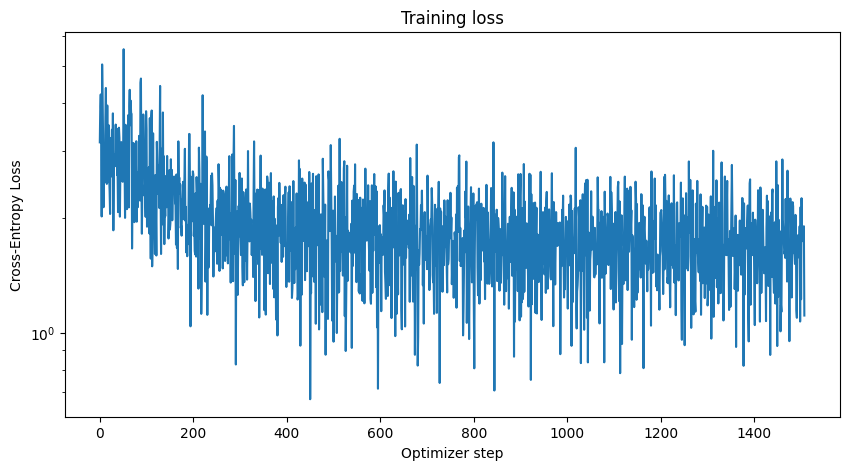

In [ ]:
# ───────────────────────────────────────────────────────────
# 1. INSTALLS & IMPORTS (assume in Colab or Notebook)
# ───────────────────────────────────────────────────────────
# !pip install pennylane pennylane-lightning[gpu] --quiet --upgrade
# !pip install torch --quiet --upgrade
# !pip install scikit-learn --quiet --upgrade

import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split

# ───────────────────────────────────────────────────────────
# 2. CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

NUM_CLASSES         = 6
INPUT_DIM           = 6
WORK_QUBITS         = math.ceil(math.log2(NUM_CLASSES))
ANCILLA_QUBITS      = 2  # Unused here for simple classification, using only work register
WIRES               = [f"q{i}" for i in range(WORK_QUBITS)]
BATCH_SIZE          = 6
INITIAL_DEPTH       = 8
MAX_DEPTH           = 8
PATIENCE_STEPS      = 25
LR                  = 3e-3
MAX_EPOCHS          = 500
CLIP_NORM           = 1.0

# ───────────────────────────────────────────────────────────
# 3. DATASET PREPARATION (Covertype demo, supervised!)
# ───────────────────────────────────────────────────────────
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler

# Load and subsample for quantum-friendliness
X_cov, y_cov = fetch_covtype(return_X_y=True)
# Use only NUM_CLASSES, and a modest number per class for speed/qubit constraint
SUBSAMPLES_PER_CLASS = 16  # feel free to adjust

X_list, y_list = [], []
for cls_val in range(1, NUM_CLASSES+1):  # Covertype labels are 1-based
    idx = (y_cov == cls_val)
    Xc = X_cov[idx][:SUBSAMPLES_PER_CLASS,:INPUT_DIM]
    yc = y_cov[idx][:SUBSAMPLES_PER_CLASS]
    X_list.append(Xc)
    y_list.append(yc)
X = np.concatenate(X_list)
y = np.concatenate(y_list)

# Scale features
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y - 1, dtype=torch.long)  # Labels now in {0,1,...,NUM_CLASSES-1}

# Train/test split (hold out 20% for test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ───────────────────────────────────────────────────────────
# 4. DEVICE SETUP
# ───────────────────────────────────────────────────────────
try:
    dev = qml.device("lightning.gpu", wires=WIRES)
except Exception:
    dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 5. CIRCUIT + MODEL
# ───────────────────────────────────────────────────────────
def entangle_block(wires):
    for i in range(len(wires)-1):
        qml.CNOT(wires=[wires[i], wires[i+1]])

class PQCLayer(nn.Module):
    def __init__(self, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(len(wires)) * 0.1)
    def forward(self):
        return self.theta

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(thetas, x_in):
    # Feature encoding
    for k in range(min(len(x_in), len(WIRES))):
        qml.RY(x_in[k], wires=WIRES[k])
    # PQC layers
    for layer_angles in thetas:
        for w, wire in enumerate(WIRES):
            qml.RY(layer_angles[w], wires=wire)
        entangle_block(WIRES)
    return qml.state()

class QuantumClassifier(nn.Module):
    def __init__(self, init_depth=INITIAL_DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(WIRES) for _ in range(init_depth)])
    @property
    def depth(self): return len(self.layers)
    def thetas(self): return torch.stack([layer() for layer in self.layers])
    def forward(self, x_batch):
        thetas = self.thetas()
        states = [circuit(thetas, x) for x in x_batch]
        # Each state: size (2**WORK_QUBITS,)
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 6. LOSS & EVALUATION
# ───────────────────────────────────────────────────────────
def basis_prob_vector(state): # Probabilities of computational basis
    probs = torch.abs(state) ** 2
    return probs / torch.sum(probs)

def cross_entropy_from_state(state, label):
    # Target is |label> basis state (One-hot)
    probs = basis_prob_vector(state)
    return -torch.log(probs[label] + 1e-9) # add eps for log(0)

def batch_loss(model, batch):
    x_b, y_b = batch
    states = model(x_b)
    losses = torch.stack([
        cross_entropy_from_state(states[i], y_b[i].item())
        for i in range(len(y_b))
    ])
    return losses.mean()

def predict_batch(model, loader):
    model.eval()
    all_preds, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out_states = model(xb)
            probs = torch.abs(out_states) ** 2  # shape (batch, D)
            pred_labels = probs.argmax(dim=1)
            all_preds.append(pred_labels.cpu())
            all_y.append(yb.cpu())
    return torch.cat(all_preds), torch.cat(all_y)


def evaluate_fidelity(model, loader, n_classes=NUM_CLASSES):
    """
    Report average fidelity between the prepared quantum state and
    the ideal basis state |y> across all tested samples.
    """
    model.eval()
    per_class_fid = {c: [] for c in range(n_classes)}
    with torch.no_grad():
        for xb, lb in loader:
            states = model(xb)
            for i in range(len(lb)):
                target_basis_index = lb[i].item()
                target = torch.zeros(states.shape[1], dtype=states.dtype)
                target[target_basis_index] = 1.0
                psi = states[i] / torch.linalg.norm(states[i])
                fid = torch.abs(torch.dot(torch.conj(psi), target)) ** 2
                per_class_fid[target_basis_index].append(fid.cpu().item())
    avg_class_fid = {k: np.mean(v) if len(v) > 0 else 0. for k, v in per_class_fid.items()}
    avg_fid = float(np.mean([x for v in per_class_fid.values() for x in v]))
    for k, v in avg_class_fid.items():
        print(f"Class {k}: Fidelity = {v:.4f}")
    print(f"Average Fidelity: {avg_fid:.4f}")
    return avg_class_fid, avg_fid

# ───────────────────────────────────────────────────────────
# 7. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumClassifier()
    opt = AdamW(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=PATIENCE_STEPS//2, min_lr=1e-5)
    best_loss, plateau = float("inf"), 0
    best_state = None
    best_depth = INITIAL_DEPTH
    losses = []
    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        for batch in train_loader:
            opt.zero_grad(set_to_none=True)
            loss = batch_loss(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
            losses.append(loss.item())
        sched.step(loss)
        # Track best
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item()
            best_state = model.state_dict()
            best_depth = model.depth
            plateau = 0
        else:
            plateau += 1
        # Dynamic depth
        if plateau > PATIENCE_STEPS and model.depth < MAX_DEPTH:
            print(f"[epoch {epoch}] plateau → adding 2 layers (depth {model.depth + 2})")
            model.layers.extend([PQCLayer(WIRES) for _ in range(2)])
            opt = AdamW(model.parameters(), lr=opt.param_groups[0]["lr"])
            plateau = 0
        if epoch % 20 == 0 or epoch == 1:
            print(f"epoch {epoch:4d} | train_loss {loss.item():.6f} | depth {model.depth}")
        if plateau > 2 * PATIENCE_STEPS:
            print(f"early stop @ epoch {epoch}")
            break
    # Restore best
    best_model = QuantumClassifier(init_depth=best_depth)
    best_model.load_state_dict(best_state)
    return best_model, losses

# ───────────────────────────────────────────────────────────
# 8. MAIN LOGIC
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Training set metrics
    pred_train, true_train = predict_batch(model, train_loader)
    train_acc = float((pred_train == true_train).float().mean())
    print(f"\nTrain accuracy: {train_acc*100:.2f}%")
    print("Train set fidelities:")
    train_fid_class, train_fid = evaluate_fidelity(model, train_loader)

    # Test set metrics (Holdout)
    pred_test, true_test = predict_batch(model, test_loader)
    test_acc = float((pred_test == true_test).float().mean())
    print(f"\nTest accuracy: {test_acc*100:.2f}%")
    print("Test set fidelities:")
    test_fid_class, test_fid = evaluate_fidelity(model, test_loader)

    # Plots if desired
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Optimizer step")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Training loss")
    plt.show()


Using device: default.qubit
epoch    1 | train_loss 3.130449 | depth 12

Training wall-time: 13.6s

Train accuracy: 10.53%
Train set fidelities:
Class 0: Fidelity = 0.3167
Class 1: Fidelity = 0.0676
Class 2: Fidelity = 0.2006
Class 3: Fidelity = 0.0408
Class 4: Fidelity = 0.0391
Class 5: Fidelity = 0.0265
Average Fidelity: 0.1172

Test accuracy: 10.00%
Test set fidelities:
Class 0: Fidelity = 0.3932
Class 1: Fidelity = 0.1309
Class 2: Fidelity = 0.1417
Class 3: Fidelity = 0.0340
Class 4: Fidelity = 0.0248
Class 5: Fidelity = 0.0388
Average Fidelity: 0.1174


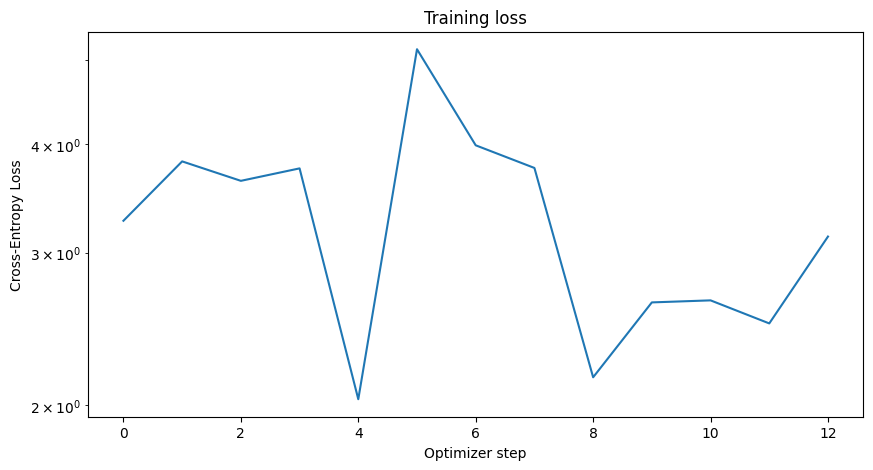

In [ ]:
# ───────────────────────────────────────────────────────────
# 1. INSTALLS & IMPORTS (assume in Colab or Notebook)
# ───────────────────────────────────────────────────────────
# !pip install pennylane pennylane-lightning[gpu] --quiet --upgrade
# !pip install torch --quiet --upgrade
# !pip install scikit-learn --quiet --upgrade

import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split

# ───────────────────────────────────────────────────────────
# 2. CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

NUM_CLASSES         = 6
INPUT_DIM           = 16
WORK_QUBITS         = math.ceil(math.log2(NUM_CLASSES))
ANCILLA_QUBITS      = 2  # Unused here for simple classification, using only work register
WIRES               = [f"q{i}" for i in range(WORK_QUBITS)]
BATCH_SIZE          = 6
INITIAL_DEPTH       = 12
MAX_DEPTH           = 12
PATIENCE_STEPS      = 25
LR                  = 3e-3
MAX_EPOCHS          = 1
CLIP_NORM           = 1.0

# ───────────────────────────────────────────────────────────
# 3. DATASET PREPARATION (Covertype demo, supervised!)
# ───────────────────────────────────────────────────────────
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler

# Load and subsample for quantum-friendliness
X_cov, y_cov = fetch_covtype(return_X_y=True)
# Use only NUM_CLASSES, and a modest number per class for speed/qubit constraint
SUBSAMPLES_PER_CLASS = 16  # feel free to adjust

X_list, y_list = [], []
for cls_val in range(1, NUM_CLASSES+1):  # Covertype labels are 1-based
    idx = (y_cov == cls_val)
    Xc = X_cov[idx][:SUBSAMPLES_PER_CLASS,:INPUT_DIM]
    yc = y_cov[idx][:SUBSAMPLES_PER_CLASS]
    X_list.append(Xc)
    y_list.append(yc)
X = np.concatenate(X_list)
y = np.concatenate(y_list)

# Scale features
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y - 1, dtype=torch.long)  # Labels now in {0,1,...,NUM_CLASSES-1}

# Train/test split (hold out 20% for test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ───────────────────────────────────────────────────────────
# 4. DEVICE SETUP
# ───────────────────────────────────────────────────────────
try:
    dev = qml.device("default.qubit", wires=WIRES)
except Exception:
    dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 5. CIRCUIT + MODEL
# ───────────────────────────────────────────────────────────
def entangle_block(wires):
    for i in range(len(wires)-1):
        qml.CNOT(wires=[wires[i], wires[i+1]])

class PQCLayer(nn.Module):
    def __init__(self, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(len(wires)) * 0.1)
    def forward(self):
        return self.theta

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(thetas, x_in):
    # Feature encoding
    for k in range(min(len(x_in), len(WIRES))):
        qml.RY(x_in[k], wires=WIRES[k])
    # PQC layers
    for layer_angles in thetas:
        for w, wire in enumerate(WIRES):
            qml.RY(layer_angles[w], wires=wire)
        entangle_block(WIRES)
    return qml.state()

class QuantumClassifier(nn.Module):
    def __init__(self, init_depth=INITIAL_DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(WIRES) for _ in range(init_depth)])
    @property
    def depth(self): return len(self.layers)
    def thetas(self): return torch.stack([layer() for layer in self.layers])
    def forward(self, x_batch):
        thetas = self.thetas()
        states = [circuit(thetas, x) for x in x_batch]
        # Each state: size (2**WORK_QUBITS,)
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 6. LOSS & EVALUATION
# ───────────────────────────────────────────────────────────
def basis_prob_vector(state): # Probabilities of computational basis
    probs = torch.abs(state) ** 2
    return probs / torch.sum(probs)

def cross_entropy_from_state(state, label):
    # Target is |label> basis state (One-hot)
    probs = basis_prob_vector(state)
    return -torch.log(probs[label] + 1e-9) # add eps for log(0)

def batch_loss(model, batch):
    x_b, y_b = batch
    states = model(x_b)
    losses = torch.stack([
        cross_entropy_from_state(states[i], y_b[i].item())
        for i in range(len(y_b))
    ])
    return losses.mean()

def predict_batch(model, loader):
    model.eval()
    all_preds, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out_states = model(xb)
            probs = torch.abs(out_states) ** 2  # shape (batch, D)
            pred_labels = probs.argmax(dim=1)
            all_preds.append(pred_labels.cpu())
            all_y.append(yb.cpu())
    return torch.cat(all_preds), torch.cat(all_y)


def evaluate_fidelity(model, loader, n_classes=NUM_CLASSES):
    """
    Report average fidelity between the prepared quantum state and
    the ideal basis state |y> across all tested samples.
    """
    model.eval()
    per_class_fid = {c: [] for c in range(n_classes)}
    with torch.no_grad():
        for xb, lb in loader:
            states = model(xb)
            for i in range(len(lb)):
                target_basis_index = lb[i].item()
                target = torch.zeros(states.shape[1], dtype=states.dtype)
                target[target_basis_index] = 1.0
                psi = states[i] / torch.linalg.norm(states[i])
                fid = torch.abs(torch.dot(torch.conj(psi), target)) ** 2
                per_class_fid[target_basis_index].append(fid.cpu().item())
    avg_class_fid = {k: np.mean(v) if len(v) > 0 else 0. for k, v in per_class_fid.items()}
    avg_fid = float(np.mean([x for v in per_class_fid.values() for x in v]))
    for k, v in avg_class_fid.items():
        print(f"Class {k}: Fidelity = {v:.4f}")
    print(f"Average Fidelity: {avg_fid:.4f}")
    return avg_class_fid, avg_fid

# ───────────────────────────────────────────────────────────
# 7. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumClassifier()
    opt = AdamW(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=PATIENCE_STEPS//2, min_lr=1e-5)
    best_loss, plateau = float("inf"), 0
    best_state = None
    best_depth = INITIAL_DEPTH
    losses = []
    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        for batch in train_loader:
            opt.zero_grad(set_to_none=True)
            loss = batch_loss(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
            losses.append(loss.item())
        sched.step(loss)
        # Track best
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item()
            best_state = model.state_dict()
            best_depth = model.depth
            plateau = 0
        else:
            plateau += 1
        # Dynamic depth
        if plateau > PATIENCE_STEPS and model.depth < MAX_DEPTH:
            print(f"[epoch {epoch}] plateau → adding 2 layers (depth {model.depth + 2})")
            model.layers.extend([PQCLayer(WIRES) for _ in range(2)])
            opt = AdamW(model.parameters(), lr=opt.param_groups[0]["lr"])
            plateau = 0
        if epoch % 20 == 0 or epoch == 1:
            print(f"epoch {epoch:4d} | train_loss {loss.item():.6f} | depth {model.depth}")
    # Restore best
    best_model = QuantumClassifier(init_depth=best_depth)
    best_model.load_state_dict(best_state)
    return best_model, losses

# ───────────────────────────────────────────────────────────
# 8. MAIN LOGIC
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Training set metrics
    pred_train, true_train = predict_batch(model, train_loader)
    train_acc = float((pred_train == true_train).float().mean())
    print(f"\nTrain accuracy: {train_acc*100:.2f}%")
    print("Train set fidelities:")
    train_fid_class, train_fid = evaluate_fidelity(model, train_loader)

    # Test set metrics (Holdout)
    pred_test, true_test = predict_batch(model, test_loader)
    test_acc = float((pred_test == true_test).float().mean())
    print(f"\nTest accuracy: {test_acc*100:.2f}%")
    print("Test set fidelities:")
    test_fid_class, test_fid = evaluate_fidelity(model, test_loader)

    # Plots if desired
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Optimizer step")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Training loss")
    plt.show()


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
X, y = fetch_covtype(return_X_y=True)
X = X[:1000]  # Reduce size for memory efficiency
y = y[:1000]

# Preprocess labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Normalize features and reduce size to power of 2 for AmplitudeEmbedding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled[:, :8]  # AmplitudeEmbedding requires 2^n features (e.g., 8)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define the quantum device
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Torch-compatible model
class QuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (3, n_qubits, 3)}  # (layers, wires, rotations)
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.fc = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        x = self.qlayer(x)
        return self.fc(x)

# Convert to torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Training
model = QuantumNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs = 10000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = loss_fn(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        predictions = torch.argmax(test_outputs, axis=1)
        acc = (predictions == y_test_torch).sum().item() / len(y_test_torch)
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Test Accuracy = {acc:.4f}")


Streaming output truncated to the last 5000 lines.
Epoch 5001: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5002: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5003: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5004: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5005: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5006: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5007: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5008: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5009: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5010: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5011: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5012: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5013: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5014: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5015: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5016: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5017: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5018: Loss = 0.7515, Test Accuracy = 0.6200
Epoch 5019: Loss = 0.7515, Test Accuracy = 0.6200

Using device: default.qubit
epoch    1 | loss 0.837387 | depth 8
epoch   20 | loss 0.157265 | depth 8
epoch   40 | loss 0.161744 | depth 8
epoch   60 | loss 0.081130 | depth 8
epoch   80 | loss 0.182773 | depth 8
epoch  100 | loss 0.178100 | depth 8
epoch  120 | loss 0.101039 | depth 8
epoch  140 | loss 0.109284 | depth 8
epoch  160 | loss 0.175712 | depth 8
early stop @ epoch 172

Training wall-time: 4368.0s

── Test Set Fidelities ──
sample  0 (state 2) → 0.803272
sample  1 (state 5) → 0.941658
sample  2 (state 4) → 0.968008
sample  3 (state 3) → 0.728335
sample  4 (state 0) → 0.825992
sample  5 (state 1) → 0.715458
sample  6 (state 2) → 0.854315
sample  7 (state 3) → 0.722260
sample  8 (state 1) → 0.870601
sample  9 (state 6) → 0.978731
sample 10 (state 0) → 0.734418
sample 11 (state 2) → 0.287633
sample 12 (state 6) → 0.984813
sample 13 (state 1) → 0.863451
sample 14 (state 4) → 0.955491
sample 15 (state 6) → 0.980628
sample 16 (state 4) → 0.860224
sample 17 (state 0) → 0.512471
sa

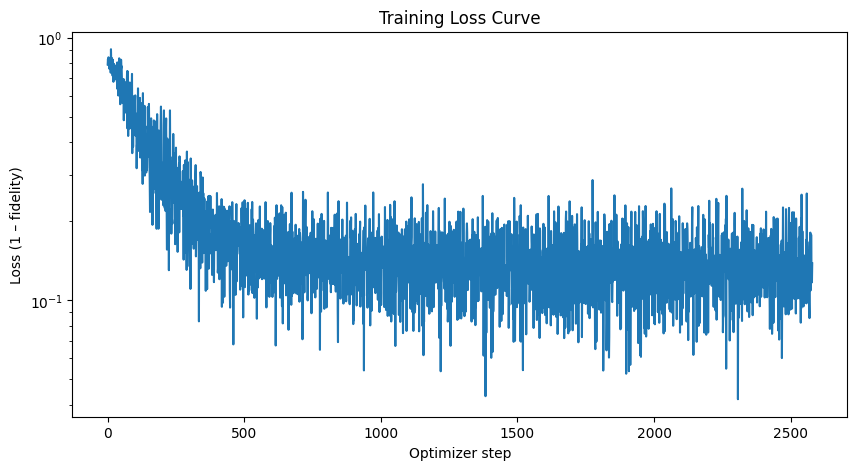

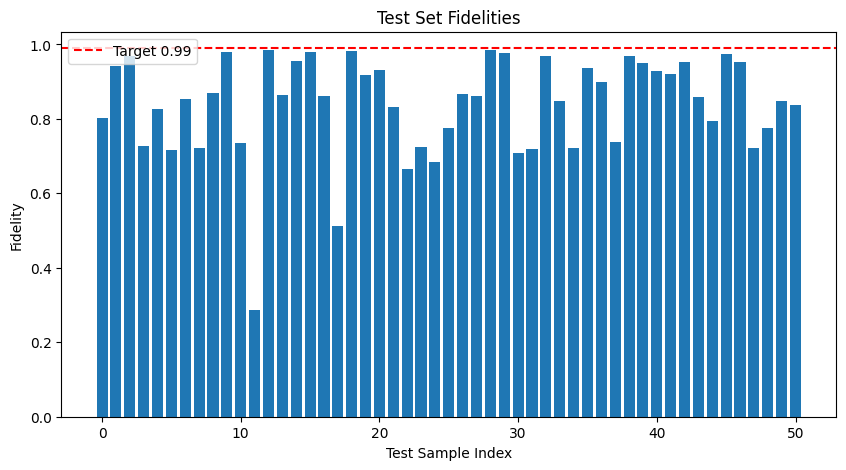

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 7               # number of labelled targets
INPUT_DIM          = 4                # length of classical feature-vector
WORK_QUBITS        = 2                # modelling register
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))
WIRES              = [f"a{i}" for i in range(ANCILLA_QUBITS)] + \
                     [f"q{i}" for i in range(WORK_QUBITS)]
BATCH_SIZE         = 8                # mini-batch size
INITIAL_DEPTH      = 8                # parametric layers to start with
MAX_DEPTH          = 8               # hard cap on depth expansion
PATIENCE_STEPS     = 25               # plateau patience before growing depth
LR                 = 3e-3
MAX_EPOCHS         = 700
CLIP_NORM          = 1.0              # gradient-clipping threshold

# ───────────────────────────────────────────────────────────
# 2. DATASET
# ───────────────────────────────────────────────────────────
# def generate_data(n_samples: int, in_dim: int):
#     x = np.random.randn(n_samples, in_dim)
#     y = np.random.rand(n_samples, 2**WORK_QUBITS) + 0.1
#     y = y / np.linalg.norm(y, axis=1, keepdims=True)
#     return (
#         torch.tensor(x, dtype=torch.float32),
#         torch.tensor(y, dtype=torch.complex128)      # complex targets
#     )

# X, Y = generate_data(NUM_STATES, INPUT_DIM)
# state_indices = torch.arange(NUM_STATES, dtype=torch.int64)
# dataset = TensorDataset(X, Y, state_indices)
# loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
#                      shuffle=True, generator=torch.Generator().manual_seed(SEED))


# ───────────────────────────────────────────────────────────
# 2. DATASET (Covertype integration with train-test split)
# ───────────────────────────────────────────────────────────
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as onp

# Load dataset
X_cov, y_cov = fetch_covtype(return_X_y=True)

# Select NUM_STATES classes
unique_classes = onp.unique(y_cov)
assert len(unique_classes) >= NUM_STATES, "Not enough unique classes."

SAMPLES_PER_CLASS = BATCH_SIZE * 3  # for training and testing

selected_class_indices = onp.concatenate([
    onp.where(y_cov == cls)[0][:SAMPLES_PER_CLASS]
    for cls in unique_classes[:NUM_STATES]
])

# Extract subset
X = X_cov[selected_class_indices, :INPUT_DIM]
y = y_cov[selected_class_indices]

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Generate complex targets for each class
real = onp.random.rand(NUM_STATES, 2**WORK_QUBITS)
imag = onp.random.rand(NUM_STATES, 2**WORK_QUBITS)
Y_class_targets = real + 1j * imag + 0.1
Y_class_targets /= onp.linalg.norm(Y_class_targets, axis=1, keepdims=True)

# Assign targets
Y = onp.array([Y_class_targets[int(label)-1] for label in y])  # covertype labels start from 1

# Train-test split
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X, Y, y, test_size=0.3, stratify=y, random_state=SEED
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.complex128)
y_train = torch.tensor(y_train - 1, dtype=torch.int64)  # 0-based index

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.complex128)
y_test = torch.tensor(y_test - 1, dtype=torch.int64)

# Train DataLoader
dataset = TensorDataset(X_train, Y_train, y_train)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                    generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
try:
    dev = qml.device("lightning.gpu", wires=WIRES)
except Exception:
    dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(wires):
    """Nearest-neighbour CNOT ladder."""
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

class PQCLayer(nn.Module):
    """Single depth-unit of RY rotations on every wire."""
    def __init__(self, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(len(wires)) * 0.1)
    def forward(self):
        return self.theta

# ───────────────────────────────────────────────────────────
# 5. QNODE (single sample)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")  # Use adjoint for Lightning; backprop for default
def circuit(thetas,           # stacked angles (depth, n_wires)
            state_idx,        # integer ∈ [0, NUM_STATES-1]
            x_in):            # classical feature-vector (INPUT_DIM,)
    # 5.1 encode ancilla address |j⟩
    binary = format(state_idx, f"0{ANCILLA_QUBITS}b")
    for pos, bit in enumerate(binary):
        if bit == "1":
            qml.PauliX(wires=f"a{pos}")

    # 5.2 classical data → rotations
    for k in range(min(len(x_in), len(WIRES))):
        qml.RY(x_in[k], wires=WIRES[k])

    # 5.3 parametric layers
    for layer_angles in thetas:
        for w, wire in enumerate(WIRES):
            qml.RY(layer_angles[w], wires=wire)
        entangle_block(WIRES)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, init_depth=INITIAL_DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(WIRES) for _ in range(init_depth)])
    @property
    def depth(self): return len(self.layers)
    def thetas(self): return torch.stack([layer() for layer in self.layers])
    def forward(self, indices, x_batch):
        """Run a mini-batch of |indices⟩ with classical inputs x_batch."""
        states = [circuit(self.thetas(), idx.item(), x)
                  for idx, x in zip(indices, x_batch)]
        return torch.stack(states)     # (batch, 2**(anc+work))

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, subspace_idx):
    """Extract amplitudes of the work-qubit subspace matching ancilla = subspace_idx."""
    offset = subspace_idx * (2 ** WORK_QUBITS)
    end    = offset + (2 ** WORK_QUBITS)
    return full_state[..., offset:end]

def cost(model, batch):
    x_b, y_b, idx_b = batch
    full_states = model(idx_b, x_b)              # (B, 2**(anc+work))
    preds = torch.stack([slice_work_register(full_states[i], idx_b[i])
                         for i in range(len(idx_b))])
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP WITH DYNAMIC DEPTH (FIXED STATE LOADING)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = AdamW(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=PATIENCE_STEPS // 2,
                          min_lr=1e-5)

    best_loss, plateau = float("inf"), 0
    best_state = None
    best_depth = INITIAL_DEPTH  # Track best depth for reconstruction
    losses = []

    for epoch in range(1, MAX_EPOCHS + 1):
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
            losses.append(loss.item())

        sched.step(loss)

        # plateau tracking
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item()
            best_state = model.state_dict()
            best_depth = model.depth  # Save the depth at this best point
            plateau = 0
        else:
            plateau += 1

        # dynamic depth growth
        if plateau > PATIENCE_STEPS and model.depth < MAX_DEPTH:
            print(f"[epoch {epoch}] plateau → adding 2 layers (depth {model.depth + 2})")
            model.layers.extend([PQCLayer(WIRES) for _ in range(2)])
            opt = AdamW(model.parameters(), lr=opt.param_groups[0]["lr"])
            plateau = 0

        if epoch % 20 == 0 or epoch == 1:
            print(f"epoch {epoch:4d} | loss {loss.item():.6f} | depth {model.depth}")

        if plateau > 2 * PATIENCE_STEPS:
            print(f"early stop @ epoch {epoch}")
            break

    # Reconstruct model with best depth and load state (fixes mismatch)
    best_model = QuantumModel(init_depth=best_depth)
    best_model.load_state_dict(best_state)
    return best_model, losses

# ───────────────────────────────────────────────────────────
# 9. FINAL EVALUATION ON TEST SET
# ───────────────────────────────────────────────────────────
def evaluate(model, X_eval, Y_eval, y_eval):
    print("\n── Test Set Fidelities ──")
    fids = []
    with torch.no_grad():
        thetas = model.thetas()
        for i in range(len(X_eval)):
            state_idx = y_eval[i].item()
            psi = circuit(thetas, state_idx, X_eval[i])
            pred = slice_work_register(psi, state_idx)
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            else:
                pred = torch.zeros_like(pred)
            fid = torch.abs(torch.dot(torch.conj(pred), Y_eval[i])) ** 2
            fids.append(fid.item())
            print(f"sample {i:2d} (state {state_idx}) → {fid.item():.6f}")
    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")
    return fids


# ───────────────────────────────────────────────────────────
# 10. MAIN
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Evaluation on test set
    fids = evaluate(model, X_test, Y_test, y_test)

    # Plotting
    import matplotlib.pyplot as plt

    # Training curve
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Optimizer step")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve")
    plt.show()

    # Fidelity plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(fids)), fids)
    plt.axhline(0.99, color="r", linestyle="--", label="Target 0.99")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Fidelity")
    plt.title("Test Set Fidelities")
    plt.legend()
    plt.show()


Using device: default.qubit
epoch    1 | loss 0.328484 | depth 10
epoch   20 | loss 0.274229 | depth 10
epoch   40 | loss 0.156316 | depth 10
epoch   60 | loss 0.082175 | depth 10
epoch   80 | loss 0.181622 | depth 10
[epoch 99] plateau → adding 2 layers (depth 12)
epoch  100 | loss 0.286944 | depth 12
epoch  120 | loss 0.168270 | depth 12
epoch  140 | loss 0.181907 | depth 12
early stop @ epoch 150

Training wall-time: 6527.2s

── Test Set Fidelities ──
sample  0 (state 2) → 0.464540
sample  1 (state 5) → 0.588486
sample  2 (state 4) → 0.892100
sample  3 (state 3) → 0.677115
sample  4 (state 0) → 0.856046
sample  5 (state 1) → 0.776993
sample  6 (state 2) → 0.795017
sample  7 (state 3) → 0.401007
sample  8 (state 1) → 0.832774
sample  9 (state 6) → 0.277206
sample 10 (state 0) → 0.678573
sample 11 (state 2) → 0.193450
sample 12 (state 6) → 0.877816
sample 13 (state 1) → 0.814877
sample 14 (state 4) → 0.834903
sample 15 (state 6) → 0.264358
sample 16 (state 4) → 0.916533
sample 17 (sta

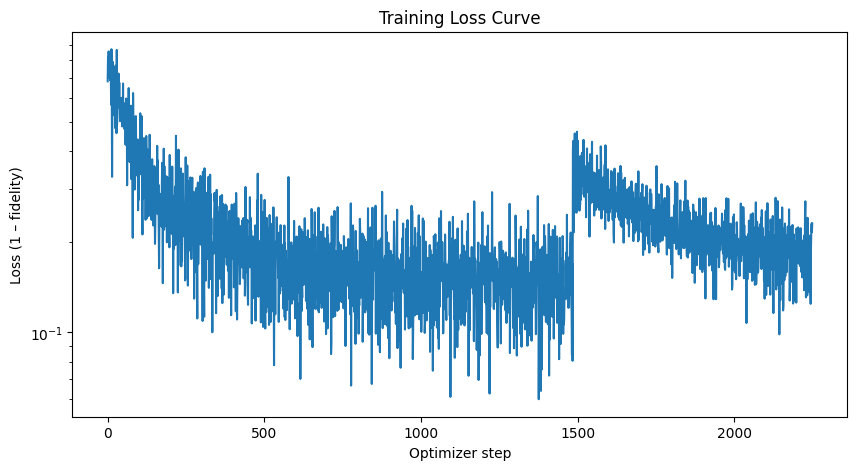

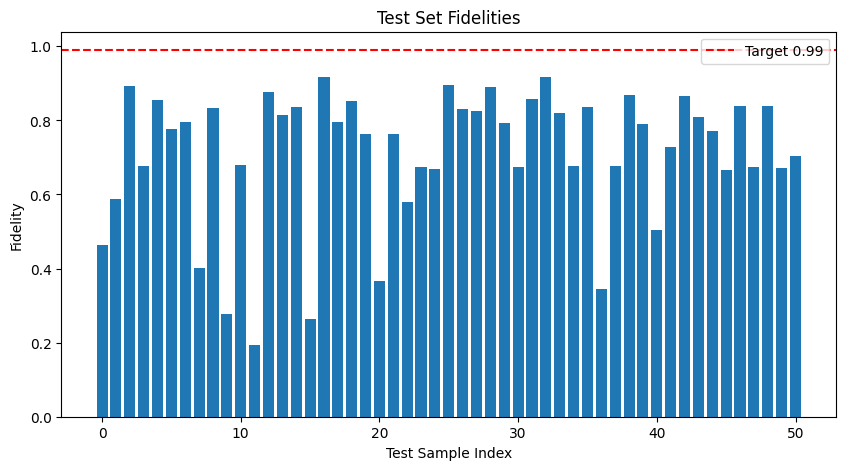

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 7               # number of labelled targets
INPUT_DIM          = 4                # length of classical feature-vector
WORK_QUBITS        = 2                # modelling register
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))
WIRES              = [f"a{i}" for i in range(ANCILLA_QUBITS)] + \
                     [f"q{i}" for i in range(WORK_QUBITS)]
BATCH_SIZE         = 8                # mini-batch size
INITIAL_DEPTH      = 10                # parametric layers to start with
MAX_DEPTH          = 12               # hard cap on depth expansion
PATIENCE_STEPS     = 25               # plateau patience before growing depth
LR                 = 3e-3
MAX_EPOCHS         = 200
CLIP_NORM          = 1.0              # gradient-clipping threshold

# ───────────────────────────────────────────────────────────
# 2. DATASET
# ───────────────────────────────────────────────────────────
# def generate_data(n_samples: int, in_dim: int):
#     x = np.random.randn(n_samples, in_dim)
#     y = np.random.rand(n_samples, 2**WORK_QUBITS) + 0.1
#     y = y / np.linalg.norm(y, axis=1, keepdims=True)
#     return (
#         torch.tensor(x, dtype=torch.float32),
#         torch.tensor(y, dtype=torch.complex128)      # complex targets
#     )

# X, Y = generate_data(NUM_STATES, INPUT_DIM)
# state_indices = torch.arange(NUM_STATES, dtype=torch.int64)
# dataset = TensorDataset(X, Y, state_indices)
# loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
#                      shuffle=True, generator=torch.Generator().manual_seed(SEED))


# ───────────────────────────────────────────────────────────
# 2. DATASET (Covertype integration with train-test split)
# ───────────────────────────────────────────────────────────
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as onp

# Load dataset
X_cov, y_cov = fetch_covtype(return_X_y=True)

# Select NUM_STATES classes
unique_classes = onp.unique(y_cov)
assert len(unique_classes) >= NUM_STATES, "Not enough unique classes."

SAMPLES_PER_CLASS = BATCH_SIZE * 3  # for training and testing

selected_class_indices = onp.concatenate([
    onp.where(y_cov == cls)[0][:SAMPLES_PER_CLASS]
    for cls in unique_classes[:NUM_STATES]
])

# Extract subset
X = X_cov[selected_class_indices, :INPUT_DIM]
y = y_cov[selected_class_indices]

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Generate complex targets for each class
real = onp.random.rand(NUM_STATES, 2**WORK_QUBITS)
imag = onp.random.rand(NUM_STATES, 2**WORK_QUBITS)
Y_class_targets = real + 1j * imag + 0.1
Y_class_targets /= onp.linalg.norm(Y_class_targets, axis=1, keepdims=True)

# Assign targets
Y = onp.array([Y_class_targets[int(label)-1] for label in y])  # covertype labels start from 1

# Train-test split
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X, Y, y, test_size=0.3, stratify=y, random_state=SEED
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.complex128)
y_train = torch.tensor(y_train - 1, dtype=torch.int64)  # 0-based index

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.complex128)
y_test = torch.tensor(y_test - 1, dtype=torch.int64)

# Train DataLoader
dataset = TensorDataset(X_train, Y_train, y_train)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                    generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
try:
    dev = qml.device("lightning.gpu", wires=WIRES)
except Exception:
    dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(wires):
    """Nearest-neighbour CNOT ladder."""
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

class PQCLayer(nn.Module):
    """Single depth-unit of RY rotations on every wire."""
    def __init__(self, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(len(wires)) * 0.1)
    def forward(self):
        return self.theta

# ───────────────────────────────────────────────────────────
# 5. QNODE (single sample)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")  # Use adjoint for Lightning; backprop for default
def circuit(thetas,           # stacked angles (depth, n_wires)
            state_idx,        # integer ∈ [0, NUM_STATES-1]
            x_in):            # classical feature-vector (INPUT_DIM,)
    # 5.1 encode ancilla address |j⟩
    binary = format(state_idx, f"0{ANCILLA_QUBITS}b")
    for pos, bit in enumerate(binary):
        if bit == "1":
            qml.PauliX(wires=f"a{pos}")

    # 5.2 classical data → rotations
    for k in range(min(len(x_in), len(WIRES))):
        qml.RY(x_in[k], wires=WIRES[k])

    # 5.3 parametric layers
    for layer_angles in thetas:
        for w, wire in enumerate(WIRES):
            qml.RY(layer_angles[w], wires=wire)
        entangle_block(WIRES)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, init_depth=INITIAL_DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(WIRES) for _ in range(init_depth)])
    @property
    def depth(self): return len(self.layers)
    def thetas(self): return torch.stack([layer() for layer in self.layers])
    def forward(self, indices, x_batch):
        """Run a mini-batch of |indices⟩ with classical inputs x_batch."""
        states = [circuit(self.thetas(), idx.item(), x)
                  for idx, x in zip(indices, x_batch)]
        return torch.stack(states)     # (batch, 2**(anc+work))

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, subspace_idx):
    """Extract amplitudes of the work-qubit subspace matching ancilla = subspace_idx."""
    offset = subspace_idx * (2 ** WORK_QUBITS)
    end    = offset + (2 ** WORK_QUBITS)
    return full_state[..., offset:end]

def cost(model, batch):
    x_b, y_b, idx_b = batch
    full_states = model(idx_b, x_b)              # (B, 2**(anc+work))
    preds = torch.stack([slice_work_register(full_states[i], idx_b[i])
                         for i in range(len(idx_b))])
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP WITH DYNAMIC DEPTH (FIXED STATE LOADING)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = AdamW(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=PATIENCE_STEPS // 2,
                          min_lr=1e-5)

    best_loss, plateau = float("inf"), 0
    best_state = None
    best_depth = INITIAL_DEPTH  # Track best depth for reconstruction
    losses = []

    for epoch in range(1, MAX_EPOCHS + 1):
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
            losses.append(loss.item())

        sched.step(loss)

        # plateau tracking
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item()
            best_state = model.state_dict()
            best_depth = model.depth  # Save the depth at this best point
            plateau = 0
        else:
            plateau += 1

        # dynamic depth growth
        if plateau > PATIENCE_STEPS and model.depth < MAX_DEPTH:
            print(f"[epoch {epoch}] plateau → adding 2 layers (depth {model.depth + 2})")
            model.layers.extend([PQCLayer(WIRES) for _ in range(2)])
            opt = AdamW(model.parameters(), lr=opt.param_groups[0]["lr"])
            plateau = 0

        if epoch % 20 == 0 or epoch == 1:
            print(f"epoch {epoch:4d} | loss {loss.item():.6f} | depth {model.depth}")

        if plateau > 2 * PATIENCE_STEPS:
            print(f"early stop @ epoch {epoch}")
            break

    # Reconstruct model with best depth and load state (fixes mismatch)
    best_model = QuantumModel(init_depth=best_depth)
    best_model.load_state_dict(best_state)
    return best_model, losses

# ───────────────────────────────────────────────────────────
# 9. FINAL EVALUATION ON TEST SET
# ───────────────────────────────────────────────────────────
def evaluate(model, X_eval, Y_eval, y_eval):
    print("\n── Test Set Fidelities ──")
    fids = []
    with torch.no_grad():
        thetas = model.thetas()
        for i in range(len(X_eval)):
            state_idx = y_eval[i].item()
            psi = circuit(thetas, state_idx, X_eval[i])
            pred = slice_work_register(psi, state_idx)
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            else:
                pred = torch.zeros_like(pred)
            fid = torch.abs(torch.dot(torch.conj(pred), Y_eval[i])) ** 2
            fids.append(fid.item())
            print(f"sample {i:2d} (state {state_idx}) → {fid.item():.6f}")
    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")
    return fids


# ───────────────────────────────────────────────────────────
# 10. MAIN
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Evaluation on test set
    fids = evaluate(model, X_test, Y_test, y_test)

    # Plotting
    import matplotlib.pyplot as plt

    # Training curve
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Optimizer step")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve")
    plt.show()

    # Fidelity plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(fids)), fids)
    plt.axhline(0.99, color="r", linestyle="--", label="Target 0.99")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Fidelity")
    plt.title("Test Set Fidelities")
    plt.legend()
    plt.show()


Using device: default.qubit
epoch    1 | loss 0.943218 | depth 8
epoch   20 | loss 0.366889 | depth 8
epoch   40 | loss 0.214539 | depth 8
epoch   60 | loss 0.196659 | depth 8
epoch   80 | loss 0.191532 | depth 8
epoch  100 | loss 0.179735 | depth 8
epoch  120 | loss 0.198474 | depth 8
epoch  140 | loss 0.240238 | depth 8
epoch  160 | loss 0.194086 | depth 8
epoch  180 | loss 0.187371 | depth 8
epoch  200 | loss 0.191889 | depth 8

Training wall-time: 8908.4s

── Test Set Fidelities ──
sample  0 (state 2) → 0.755234
sample  1 (state 5) → 0.781892
sample  2 (state 4) → 0.774449
sample  3 (state 3) → 0.844697
sample  4 (state 0) → 0.813265
sample  5 (state 1) → 0.719243
sample  6 (state 2) → 0.754622
sample  7 (state 3) → 0.528038
sample  8 (state 1) → 0.852916
sample  9 (state 6) → 0.793012
sample 10 (state 0) → 0.745318
sample 11 (state 2) → 0.268305
sample 12 (state 6) → 0.815988
sample 13 (state 1) → 0.846268
sample 14 (state 4) → 0.779731
sample 15 (state 6) → 0.790458
sample 16 (st

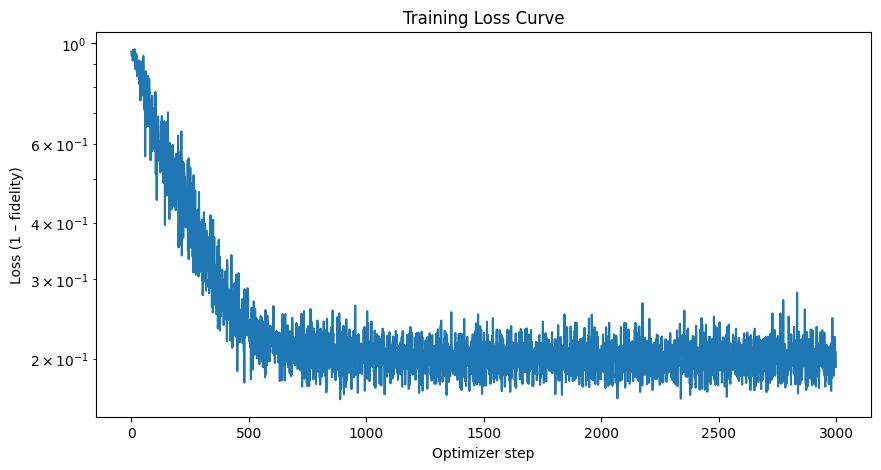

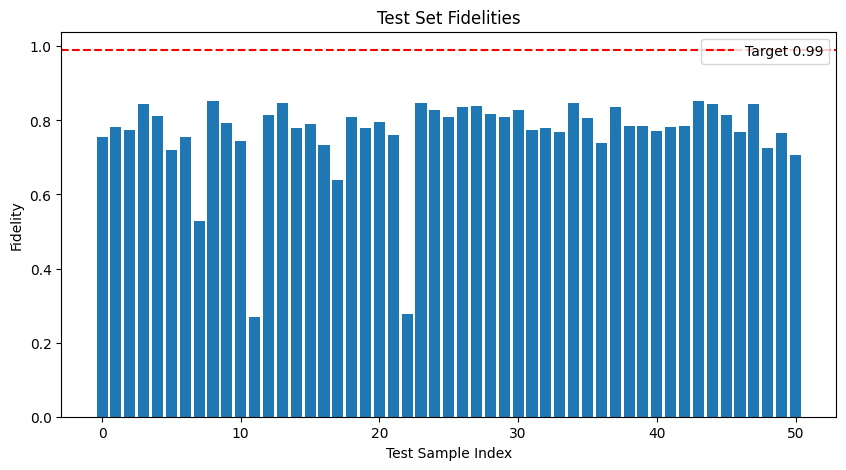

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 7               # number of labelled targets
INPUT_DIM          = 4                # length of classical feature-vector
WORK_QUBITS        = 4                # modelling register
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))
WIRES              = [f"a{i}" for i in range(ANCILLA_QUBITS)] + \
                     [f"q{i}" for i in range(WORK_QUBITS)]
BATCH_SIZE         = 8                # mini-batch size
INITIAL_DEPTH      = 8                # parametric layers to start with
MAX_DEPTH          = 8               # hard cap on depth expansion
PATIENCE_STEPS     = 25               # plateau patience before growing depth
LR                 = 3e-3
MAX_EPOCHS         = 200
CLIP_NORM          = 1.0              # gradient-clipping threshold

# ───────────────────────────────────────────────────────────
# 2. DATASET
# ───────────────────────────────────────────────────────────
# def generate_data(n_samples: int, in_dim: int):
#     x = np.random.randn(n_samples, in_dim)
#     y = np.random.rand(n_samples, 2**WORK_QUBITS) + 0.1
#     y = y / np.linalg.norm(y, axis=1, keepdims=True)
#     return (
#         torch.tensor(x, dtype=torch.float32),
#         torch.tensor(y, dtype=torch.complex128)      # complex targets
#     )

# X, Y = generate_data(NUM_STATES, INPUT_DIM)
# state_indices = torch.arange(NUM_STATES, dtype=torch.int64)
# dataset = TensorDataset(X, Y, state_indices)
# loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
#                      shuffle=True, generator=torch.Generator().manual_seed(SEED))


# ───────────────────────────────────────────────────────────
# 2. DATASET (Covertype integration with train-test split)
# ───────────────────────────────────────────────────────────
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as onp

# Load dataset
X_cov, y_cov = fetch_covtype(return_X_y=True)

# Select NUM_STATES classes
unique_classes = onp.unique(y_cov)
assert len(unique_classes) >= NUM_STATES, "Not enough unique classes."

SAMPLES_PER_CLASS = BATCH_SIZE * 3  # for training and testing

selected_class_indices = onp.concatenate([
    onp.where(y_cov == cls)[0][:SAMPLES_PER_CLASS]
    for cls in unique_classes[:NUM_STATES]
])

# Extract subset
X = X_cov[selected_class_indices, :INPUT_DIM]
y = y_cov[selected_class_indices]

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Generate complex targets for each class
real = onp.random.rand(NUM_STATES, 2**WORK_QUBITS)
imag = onp.random.rand(NUM_STATES, 2**WORK_QUBITS)
Y_class_targets = real + 1j * imag + 0.1
Y_class_targets /= onp.linalg.norm(Y_class_targets, axis=1, keepdims=True)

# Assign targets
Y = onp.array([Y_class_targets[int(label)-1] for label in y])  # covertype labels start from 1

# Train-test split
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X, Y, y, test_size=0.3, stratify=y, random_state=SEED
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.complex128)
y_train = torch.tensor(y_train - 1, dtype=torch.int64)  # 0-based index

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.complex128)
y_test = torch.tensor(y_test - 1, dtype=torch.int64)

# Train DataLoader
dataset = TensorDataset(X_train, Y_train, y_train)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                    generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
try:
    dev = qml.device("lightning.gpu", wires=WIRES)
except Exception:
    dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(wires):
    """Nearest-neighbour CNOT ladder."""
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])                                                                                                                                                                                                                                                                                                                                                      f

class PQCLayer(nn.Module):
    """Single depth-unit of RY rotations on every wire."""
    def __init__(self, wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(len(wires)) * 0.1)
    def forward(self):
        return self.theta

# ───────────────────────────────────────────────────────────
# 5. QNODE (single sample)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")  # Use adjoint for Lightning; backprop for default
def circuit(thetas,           # stacked angles (depth, n_wires)
            state_idx,        # integer ∈ [0, NUM_STATES-1]
            x_in):            # classical feature-vector (INPUT_DIM,)
    # 5.1 encode ancilla address |j⟩
    binary = format(state_idx, f"0{ANCILLA_QUBITS}b")
    for pos, bit in enumerate(binary):
        if bit == "1":
            qml.PauliX(wires=f"a{pos}")

    # 5.2 classical data → rotations
    for k in range(min(len(x_in), len(WIRES))):
        qml.RY(x_in[k], wires=WIRES[k])

    # 5.3 parametric layers
    for layer_angles in thetas:
        for w, wire in enumerate(WIRES):
            qml.RY(layer_angles[w], wires=wire)
        entangle_block(WIRES)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, init_depth=INITIAL_DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(WIRES) for _ in range(init_depth)])
    @property
    def depth(self): return len(self.layers)
    def thetas(self): return torch.stack([layer() for layer in self.layers])
    def forward(self, indices, x_batch):
        """Run a mini-batch of |indices⟩ with classical inputs x_batch."""
        states = [circuit(self.thetas(), idx.item(), x)
                  for idx, x in zip(indices, x_batch)]
        return torch.stack(states)     # (batch, 2**(anc+work))

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, subspace_idx):
    """Extract amplitudes of the work-qubit subspace matching ancilla = subspace_idx."""
    offset = subspace_idx * (2 ** WORK_QUBITS)
    end    = offset + (2 ** WORK_QUBITS)
    return full_state[..., offset:end]

def cost(model, batch):
    x_b, y_b, idx_b = batch
    full_states = model(idx_b, x_b)              # (B, 2**(anc+work))
    preds = torch.stack([slice_work_register(full_states[i], idx_b[i])
                         for i in range(len(idx_b))])
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP WITH DYNAMIC DEPTH (FIXED STATE LOADING)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = AdamW(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=PATIENCE_STEPS // 2,
                          min_lr=1e-5)

    best_loss, plateau = float("inf"), 0
    best_state = None
    best_depth = INITIAL_DEPTH  # Track best depth for reconstruction
    losses = []

    for epoch in range(1, MAX_EPOCHS + 1):
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
            losses.append(loss.item())

        sched.step(loss)

        # plateau tracking
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item()
            best_state = model.state_dict()
            best_depth = model.depth  # Save the depth at this best point
            plateau = 0
        else:
            plateau += 1

        # dynamic depth growth
        if plateau > PATIENCE_STEPS and model.depth < MAX_DEPTH:
            print(f"[epoch {epoch}] plateau → adding 2 layers (depth {model.depth + 2})")
            model.layers.extend([PQCLayer(WIRES) for _ in range(2)])
            opt = AdamW(model.parameters(), lr=opt.param_groups[0]["lr"])
            plateau = 0

        if epoch % 20 == 0 or epoch == 1:
            print(f"epoch {epoch:4d} | loss {loss.item():.6f} | depth {model.depth}")

        if plateau > 2 * PATIENCE_STEPS:
            print(f"early stop @ epoch {epoch}")
            break

    # Reconstruct model with best depth and load state (fixes mismatch)
    best_model = QuantumModel(init_depth=best_depth)
    best_model.load_state_dict(best_state)
    return best_model, losses

# ───────────────────────────────────────────────────────────
# 9. FINAL EVALUATION ON TEST SET
# ───────────────────────────────────────────────────────────
def evaluate(model, X_eval, Y_eval, y_eval):
    print("\n── Test Set Fidelities ──")
    fids = []
    with torch.no_grad():
        thetas = model.thetas()
        for i in range(len(X_eval)):
            state_idx = y_eval[i].item()
            psi = circuit(thetas, state_idx, X_eval[i])
            pred = slice_work_register(psi, state_idx)
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            else:
                pred = torch.zeros_like(pred)
            fid = torch.abs(torch.dot(torch.conj(pred), Y_eval[i])) ** 2
            fids.append(fid.item())
            print(f"sample {i:2d} (state {state_idx}) → {fid.item():.6f}")
    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")
    return fids


# ───────────────────────────────────────────────────────────
# 10. MAIN
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Evaluation on test set
    fids = evaluate(model, X_test, Y_test, y_test)

    # Plotting
    import matplotlib.pyplot as plt

    # Training curve
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Optimizer step")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve")
    plt.show()

    # Fidelity plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(fids)), fids)
    plt.axhline(0.99, color="r", linestyle="--", label="Target 0.99")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Fidelity")
    plt.title("Test Set Fidelities")
    plt.legend()
    plt.show()


Using device: default.qubit
--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.964492 | LR 0.001000
Epoch   10 | Avg Loss 0.954837 | LR 0.001000
Epoch   20 | Avg Loss 0.940871 | LR 0.001000
Epoch   30 | Avg Loss 0.922192 | LR 0.001000
Epoch   40 | Avg Loss 0.897119 | LR 0.001000
Epoch   50 | Avg Loss 0.863691 | LR 0.001000
Epoch   60 | Avg Loss 0.819870 | LR 0.001000
Epoch   70 | Avg Loss 0.764193 | LR 0.001000
Epoch   80 | Avg Loss 0.696817 | LR 0.001000
Epoch   90 | Avg Loss 0.620367 | LR 0.001000
Epoch  100 | Avg Loss 0.540118 | LR 0.001000
Epoch  110 | Avg Loss 0.463213 | LR 0.001000
Epoch  120 | Avg Loss 0.396730 | LR 0.001000
Epoch  130 | Avg Loss 0.345180 | LR 0.001000
Epoch  140 | Avg Loss 0.309131 | LR 0.001000
Epoch  150 | Avg Loss 0.286059 | LR 0.001000
Epoch  160 | Avg Loss 0.272171 | LR 0.001000
Epoch  170 | Avg Loss 0.263921 | LR 0.001000
Epoch  180 | Avg Loss 0.258712 | LR 0.001000
Epoch  190 | Avg Loss 0.254625 | LR 0.001000
Epoch  200 | Avg Loss 0.248913 | LR 0.001000
--- Training Complete ---

Training wall-time: 2013.2s


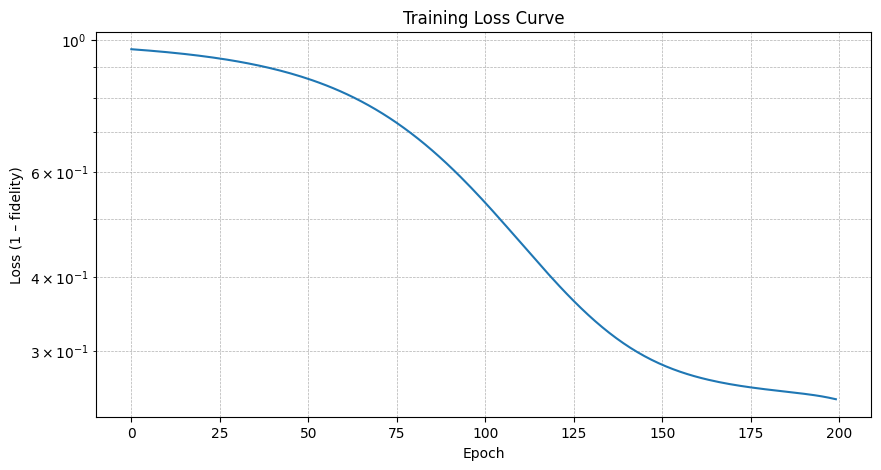

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
# CHANGED: AdamW is great, but Adam is often the standard baseline mentioned. Sticking to Adam.
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 7                                    # (g) number of states to prepare
WORK_QUBITS        = 4                                    # (n) number of data qubits
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # (x) number of ancilla qubits (ceil(log2(g)))
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 8
DEPTH              = 8                                    # (l) Fixed number of variational layers
LR                 = 1e-3
MAX_EPOCHS         = 200
# REMOVED: Dynamic depth parameters are no longer needed.
# REMOVED: INPUT_DIM is no longer needed as we are not doing conditional encoding.

# ───────────────────────────────────────────────────────────
# 2. DATASET (Generate target states directly, per the thesis)
# ───────────────────────────────────────────────────────────
def generate_data(num_states: int, num_work_qubits: int):
    """Generates a set of random, normalized quantum states to be used as targets."""
    # Generate random complex vectors
    real = np.random.rand(num_states, 2**num_work_qubits)
    imag = np.random.rand(num_states, 2**num_work_qubits)
    Y_targets = real + 1j * imag
    # Normalize each state vector
    Y_targets /= np.linalg.norm(Y_targets, axis=1, keepdims=True)
    return torch.tensor(Y_targets, dtype=torch.complex128)

# Generate the target states and corresponding indices
Y_targets = generate_data(NUM_STATES, WORK_QUBITS)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create a simple dataset of (target_state, state_index)
# We map the full dataset as we want the model to learn all states simultaneously
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES) # Simpler device for clarity
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
# CHANGED: entangle_block now takes parameters `phi` for CRX gates and is circular.
def entangle_block(phi, wires):
    """Circularly-entangled CRX layer."""
    num_wires = len(wires)
    for i in range(num_wires):
        # Entangle qubit i with qubit i+1, wrapping around at the end
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

# CHANGED: PQCLayer now holds parameters for both rotation (theta) and entanglement (phi).
class PQCLayer(nn.Module):
    """A layer of RY rotations and a parameterized CRX entanglement block."""
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1) # Parameters for CRX gates

    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas,       # (depth, n_wires) angles for RY
            crx_phis,        # (depth, n_wires) angles for CRX
            state_idx):      # integer ∈ [0, NUM_STATES-1]
    # REMOVED: x_in parameter is gone.

    # 5.1 Prepare ancilla register in state |state_idx⟩
    # CHANGED: Pass the integer state_idx directly
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))

    # 5.2 ADDED: Initial Hadamard layer, a core part of the thesis's symmetric ansatz.
    # CHANGED: Replace qml.broadcast with a loop
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # REMOVED: The conditional RY(x_in) encoding block is gone.

    # 5.3 Parametric layers (Rotation + Entanglement)
    for i in range(DEPTH):
        # Rotation Layer
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        # Entanglement Layer
        entangle_block(crx_phis[i], wires=WIRES)

    # 5.4 ADDED: Final Hadamard layer to complete the symmetric ansatz.
    # CHANGED: Replace qml.broadcast with a loop
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        # CHANGED: The number of layers is now fixed.
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])

    @property
    def depth(self): return len(self.layers)

    def get_params(self):
        # CHANGED: Stacks thetas and phis from all layers into two separate tensors.
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)

    def forward(self, indices):
        # REMOVED: x_batch is no longer an input.
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states) # (batch, 2**total_qubits)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, ancilla_qubits, work_qubits):
    """Extracts the amplitudes of the work-qubit subspace.
    This assumes ancilla qubits are the first `ancilla_qubits` wires."""
    # This function is more general now and assumes a single full_state vector
    num_work_states = 2**work_qubits
    # The ancilla state is 0 for the first subspace, 1 for the second, etc.
    # We are interested in the subspace where ancilla is in the |0...0⟩ state after circuit inversion
    # For a forward pass, we slice based on the prepared ancilla index.
    # Let's simplify and assume for cost function we can get the ancilla index
    # The previous implementation was better, let's revert that part for clarity.
    pass # Re-implementing in cost function for clarity

def cost(model, batch):
    y_b, idx_b = batch # REMOVED: x_b is gone

    full_states = model(idx_b) # (B, 2**(anc+work))

    # Post-select the correct subspace from the work register for each item in the batch
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]

        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)

        # Slicing the full state vector to get the part corresponding to the work qubits
        # when the ancilla qubits are in the state |state_idx>
        pred = full_state[offset:end]
        preds.append(pred)

    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True) # Normalize the predicted state
    fids  = fidelity(preds, y_b)

    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP (Simplified to Fixed Depth)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=10, min_lr=1e-6)

    losses = []
    print("--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")

    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Final Evaluation
    print("\n── Final Model Fidelities ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i

            full_psi = circuit(ry_thetas, crx_phis, state_idx)

            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]

            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm

            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for state {i:2d}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

Using device: default.qubit
--- Starting Training ---
Epoch    1 | Avg Loss 0.989575 | LR 0.001000
Epoch   10 | Avg Loss 0.979595 | LR 0.001000
Epoch   20 | Avg Loss 0.952111 | LR 0.001000
Epoch   30 | Avg Loss 0.894466 | LR 0.001000
Epoch   40 | Avg Loss 0.797706 | LR 0.001000
Epoch   50 | Avg Loss 0.664476 | LR 0.001000
Epoch   60 | Avg Loss 0.514198 | LR 0.001000
Epoch   70 | Avg Loss 0.376804 | LR 0.001000
Epoch   80 | Avg Loss 0.274757 | LR 0.001000
Epoch   90 | Avg Loss 0.210205 | LR 0.001000
Epoch  100 | Avg Loss 0.172103 | LR 0.001000
Epoch  110 | Avg Loss 0.149375 | LR 0.001000
Epoch  120 | Avg Loss 0.135217 | LR 0.001000
Epoch  130 | Avg Loss 0.125970 | LR 0.001000
Epoch  140 | Avg Loss 0.119540 | LR 0.001000
Epoch  150 | Avg Loss 0.114601 | LR 0.001000
Epoch  160 | Avg Loss 0.110332 | LR 0.001000
Epoch  170 | Avg Loss 0.106280 | LR 0.001000
Epoch  180 | Avg Loss 0.102222 | LR 0.001000
Epoch  190 | Avg Loss 0.098051 | LR 0.001000
Epoch  200 | Avg Loss 0.093704 | LR 0.001000
-

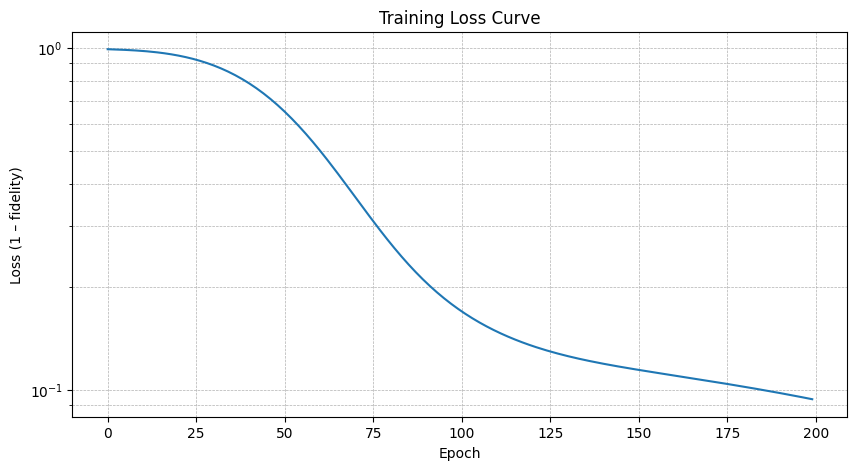

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
# CHANGED: AdamW is great, but Adam is often the standard baseline mentioned. Sticking to Adam.
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 1                                    # (g) number of states to prepare
WORK_QUBITS        = 2                                    # (n) number of data qubits
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # (x) number of ancilla qubits (ceil(log2(g)))
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 8
DEPTH              = 16                                    # (l) Fixed number of variational layers
LR                 = 1e-3
MAX_EPOCHS         = 200
# REMOVED: Dynamic depth parameters are no longer needed.
# REMOVED: INPUT_DIM is no longer needed as we are not doing conditional encoding.

# ───────────────────────────────────────────────────────────
# 2. DATASET (Generate target states directly, per the thesis)
# ───────────────────────────────────────────────────────────
def generate_data(num_states: int, num_work_qubits: int):
    """Generates a set of random, normalized quantum states to be used as targets."""
    # Generate random complex vectors
    real = np.random.rand(num_states, 2**num_work_qubits)
    imag = np.random.rand(num_states, 2**num_work_qubits)
    Y_targets = real + 1j * imag
    # Normalize each state vector
    Y_targets /= np.linalg.norm(Y_targets, axis=1, keepdims=True)
    return torch.tensor(Y_targets, dtype=torch.complex128)

# Generate the target states and corresponding indices
Y_targets = generate_data(NUM_STATES, WORK_QUBITS)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create a simple dataset of (target_state, state_index)
# We map the full dataset as we want the model to learn all states simultaneously
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES) # Simpler device for clarity
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
# CHANGED: entangle_block now takes parameters `phi` for CRX gates and is circular.
def entangle_block(phi, wires):
    """Circularly-entangled CRX layer."""
    num_wires = len(wires)
    for i in range(num_wires):
        # Entangle qubit i with qubit i+1, wrapping around at the end
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

# CHANGED: PQCLayer now holds parameters for both rotation (theta) and entanglement (phi).
class PQCLayer(nn.Module):
    """A layer of RY rotations and a parameterized CRX entanglement block."""
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1) # Parameters for CRX gates

    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas,       # (depth, n_wires) angles for RY
            crx_phis,        # (depth, n_wires) angles for CRX
            state_idx):      # integer ∈ [0, NUM_STATES-1]
    # REMOVED: x_in parameter is gone.

    # 5.1 Prepare ancilla register in state |state_idx⟩
    # CHANGED: Pass the integer state_idx directly
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))

    # 5.2 ADDED: Initial Hadamard layer, a core part of the thesis's symmetric ansatz.
    # CHANGED: Replace qml.broadcast with a loop
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # REMOVED: The conditional RY(x_in) encoding block is gone.

    # 5.3 Parametric layers (Rotation + Entanglement)
    for i in range(DEPTH):
        # Rotation Layer
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        # Entanglement Layer
        entangle_block(crx_phis[i], wires=WIRES)

    # 5.4 ADDED: Final Hadamard layer to complete the symmetric ansatz.
    # CHANGED: Replace qml.broadcast with a loop
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        # CHANGED: The number of layers is now fixed.
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])

    @property
    def depth(self): return len(self.layers)

    def get_params(self):
        # CHANGED: Stacks thetas and phis from all layers into two separate tensors.
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)

    def forward(self, indices):
        # REMOVED: x_batch is no longer an input.
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states) # (batch, 2**total_qubits)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, ancilla_qubits, work_qubits):
    """Extracts the amplitudes of the work-qubit subspace.
    This assumes ancilla qubits are the first `ancilla_qubits` wires."""
    # This function is more general now and assumes a single full_state vector
    num_work_states = 2**work_qubits
    # The ancilla state is 0 for the first subspace, 1 for the second, etc.
    # We are interested in the subspace where ancilla is in the |0...0⟩ state after circuit inversion
    # For a forward pass, we slice based on the prepared ancilla index.
    # Let's simplify and assume for cost function we can get the ancilla index
    # The previous implementation was better, let's revert that part for clarity.
    pass # Re-implementing in cost function for clarity

def cost(model, batch):
    y_b, idx_b = batch # REMOVED: x_b is gone

    full_states = model(idx_b) # (B, 2**(anc+work))

    # Post-select the correct subspace from the work register for each item in the batch
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]

        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)

        # Slicing the full state vector to get the part corresponding to the work qubits
        # when the ancilla qubits are in the state |state_idx>
        pred = full_state[offset:end]
        preds.append(pred)

    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True) # Normalize the predicted state
    fids  = fidelity(preds, y_b)

    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP (Simplified to Fixed Depth)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=10, min_lr=1e-6)

    losses = []
    print("--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")

    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Final Evaluation
    print("\n── Final Model Fidelities ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i

            full_psi = circuit(ry_thetas, crx_phis, state_idx)

            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]

            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm

            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for state {i:2d}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

Using device: default.qubit
--- Starting Training ---
Epoch    1 | Avg Loss 0.690547 | LR 0.001000
Epoch   10 | Avg Loss 0.626873 | LR 0.001000
Epoch   20 | Avg Loss 0.553686 | LR 0.001000
Epoch   30 | Avg Loss 0.482164 | LR 0.001000
Epoch   40 | Avg Loss 0.417127 | LR 0.001000
Epoch   50 | Avg Loss 0.362345 | LR 0.001000
Epoch   60 | Avg Loss 0.319470 | LR 0.001000
Epoch   70 | Avg Loss 0.288277 | LR 0.001000
Epoch   80 | Avg Loss 0.267222 | LR 0.001000
Epoch   90 | Avg Loss 0.253616 | LR 0.001000
Epoch  100 | Avg Loss 0.243964 | LR 0.001000
Epoch  110 | Avg Loss 0.234097 | LR 0.001000
Epoch  120 | Avg Loss 0.217888 | LR 0.001000
Epoch  130 | Avg Loss 0.187866 | LR 0.001000
Epoch  140 | Avg Loss 0.164648 | LR 0.001000
Epoch  150 | Avg Loss 0.143062 | LR 0.001000
Epoch  160 | Avg Loss 0.133582 | LR 0.001000
Epoch  170 | Avg Loss 0.128514 | LR 0.001000
Epoch  180 | Avg Loss 0.123752 | LR 0.001000
Epoch  190 | Avg Loss 0.119987 | LR 0.001000
Epoch  200 | Avg Loss 0.116672 | LR 0.001000
E

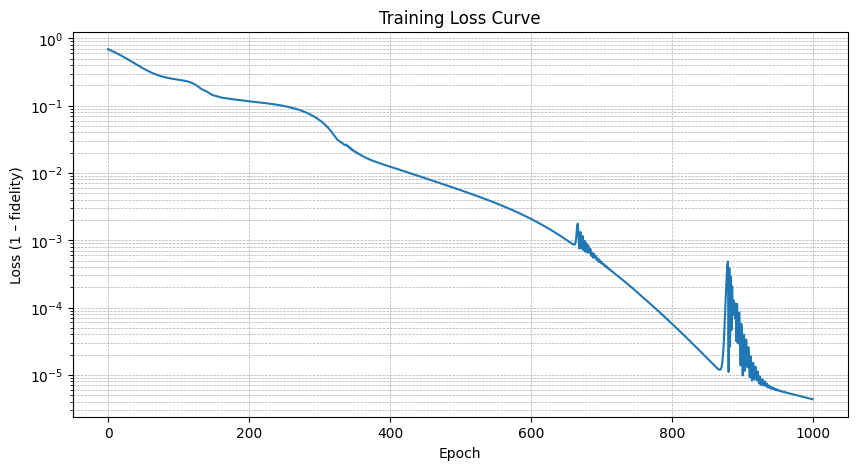

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
# CHANGED: AdamW is great, but Adam is often the standard baseline mentioned. Sticking to Adam.
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_STATES         = 4                                    # (g) number of states to prepare
WORK_QUBITS        = 2                                    # (n) number of data qubits
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # (x) number of ancilla qubits (ceil(log2(g)))
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 8
DEPTH              = 16                                    # (l) Fixed number of variational layers
LR                 = 1e-3
MAX_EPOCHS         = 1000
# REMOVED: Dynamic depth parameters are no longer needed.
# REMOVED: INPUT_DIM is no longer needed as we are not doing conditional encoding.

# ───────────────────────────────────────────────────────────
# 2. DATASET (Generate target states directly, per the thesis)
# ───────────────────────────────────────────────────────────
def generate_data(num_states: int, num_work_qubits: int):
    """Generates a set of random, normalized quantum states to be used as targets."""
    # Generate random complex vectors
    real = np.random.rand(num_states, 2**num_work_qubits)
    imag = np.random.rand(num_states, 2**num_work_qubits)
    Y_targets = real + 1j * imag
    # Normalize each state vector
    Y_targets /= np.linalg.norm(Y_targets, axis=1, keepdims=True)
    return torch.tensor(Y_targets, dtype=torch.complex128)

# Generate the target states and corresponding indices
Y_targets = generate_data(NUM_STATES, WORK_QUBITS)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create a simple dataset of (target_state, state_index)
# We map the full dataset as we want the model to learn all states simultaneously
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES) # Simpler device for clarity
print(f"Using device: {dev.name}")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
# CHANGED: entangle_block now takes parameters `phi` for CRX gates and is circular.
def entangle_block(phi, wires):
    """Circularly-entangled CRX layer."""
    num_wires = len(wires)
    for i in range(num_wires):
        # Entangle qubit i with qubit i+1, wrapping around at the end
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

# CHANGED: PQCLayer now holds parameters for both rotation (theta) and entanglement (phi).
class PQCLayer(nn.Module):
    """A layer of RY rotations and a parameterized CRX entanglement block."""
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1) # Parameters for CRX gates

    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas,       # (depth, n_wires) angles for RY
            crx_phis,        # (depth, n_wires) angles for CRX
            state_idx):      # integer ∈ [0, NUM_STATES-1]
    # REMOVED: x_in parameter is gone.

    # 5.1 Prepare ancilla register in state |state_idx⟩
    # CHANGED: Pass the integer state_idx directly
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))

    # 5.2 ADDED: Initial Hadamard layer, a core part of the thesis's symmetric ansatz.
    # CHANGED: Replace qml.broadcast with a loop
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # REMOVED: The conditional RY(x_in) encoding block is gone.

    # 5.3 Parametric layers (Rotation + Entanglement)
    for i in range(DEPTH):
        # Rotation Layer
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        # Entanglement Layer
        entangle_block(crx_phis[i], wires=WIRES)

    # 5.4 ADDED: Final Hadamard layer to complete the symmetric ansatz.
    # CHANGED: Replace qml.broadcast with a loop
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        # CHANGED: The number of layers is now fixed.
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])

    @property
    def depth(self): return len(self.layers)

    def get_params(self):
        # CHANGED: Stacks thetas and phis from all layers into two separate tensors.
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)

    def forward(self, indices):
        # REMOVED: x_batch is no longer an input.
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states) # (batch, 2**total_qubits)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    """Compute |〈pred|target〉|² for a batch of states."""
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def slice_work_register(full_state, ancilla_qubits, work_qubits):
    """Extracts the amplitudes of the work-qubit subspace.
    This assumes ancilla qubits are the first `ancilla_qubits` wires."""
    # This function is more general now and assumes a single full_state vector
    num_work_states = 2**work_qubits
    # The ancilla state is 0 for the first subspace, 1 for the second, etc.
    # We are interested in the subspace where ancilla is in the |0...0⟩ state after circuit inversion
    # For a forward pass, we slice based on the prepared ancilla index.
    # Let's simplify and assume for cost function we can get the ancilla index
    # The previous implementation was better, let's revert that part for clarity.
    pass # Re-implementing in cost function for clarity

def cost(model, batch):
    y_b, idx_b = batch # REMOVED: x_b is gone

    full_states = model(idx_b) # (B, 2**(anc+work))

    # Post-select the correct subspace from the work register for each item in the batch
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]

        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)

        # Slicing the full state vector to get the part corresponding to the work qubits
        # when the ancilla qubits are in the state |state_idx>
        pred = full_state[offset:end]
        preds.append(pred)

    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True) # Normalize the predicted state
    fids  = fidelity(preds, y_b)

    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP (Simplified to Fixed Depth)
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=10, min_lr=1e-6)

    losses = []
    print("--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")

    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    # Final Evaluation
    print("\n── Final Model Fidelities ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i

            full_psi = circuit(ry_thetas, crx_phis, state_idx)

            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]

            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm

            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for state {i:2d}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

Iris Dataset

--- Target States from Iris Dataset ---
Class 0 (setosa): [0.379 0.87  0.233 0.212]
Class 1 (versicolor): [0.49  0.374 0.575 0.539]
Class 2 (virginica): [0.478 0.331 0.565 0.585]
------------------------------------
Using device: default.qubit with [0, 1, 2, 3] wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.604016 | LR 0.001000
Epoch   20 | Avg Loss 0.490651 | LR 0.001000
Epoch   40 | Avg Loss 0.374678 | LR 0.001000
Epoch   60 | Avg Loss 0.273673 | LR 0.001000
Epoch   80 | Avg Loss 0.198078 | LR 0.001000
Epoch  100 | Avg Loss 0.150986 | LR 0.001000
Epoch  120 | Avg Loss 0.126943 | LR 0.001000
Epoch  140 | Avg Loss 0.116655 | LR 0.001000
Epoch  160 | Avg Loss 0.112229 | LR 0.001000
Epoch  180 | Avg Loss 0.109348 | LR 0.001000
Epoch  200 | Avg Loss 0.105652 | LR 0.001000
Epoch  220 | Avg Loss 0.098713 | LR 0.001000
Epoch  240 | Avg Loss 0.088495 | LR 0.001000
Epoch  260 | Avg Loss 0.073136 | LR 0.001000
Epoch  280 | Avg Loss 0.064167 | LR 0.001000
Epoch  300 | Avg Loss 0.047112 | LR 0.001000
Epoch  320 | Avg Loss 0.013622 | LR 0.001000
Epoch  340 | Avg Loss 0.005583 | LR 0.001000
Epoch  360 | Avg Loss 0.004446 | LR 0.001000
Epoch  380 | Avg Loss 0.003765 | LR 0.001000
Epoch  400 | Avg Loss 0.003360 | LR 0.001000
Epoch  420 | Avg Loss 0.003034 | LR 0.001000
Epoch  440

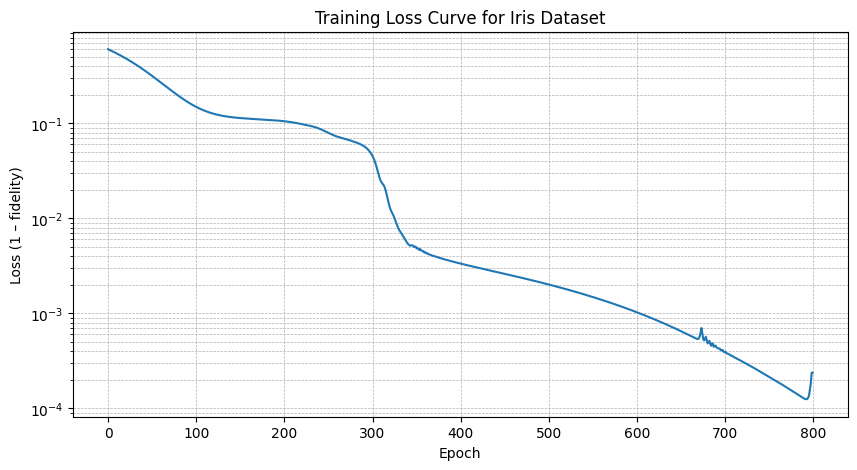

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for real-world dataset loading and preprocessing
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Iris dataset
NUM_STATES         = 3                                    # (g) Iris has 3 classes
WORK_QUBITS        = 2                                    # (n) Iris has 4 features, so we need 2^2=4 amplitudes
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # (x) ceil(log2(3)) = 2 ancilla qubits
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 3                                    # Batch size can be the number of states
DEPTH              = 10                                    # (l) Number of variational layers
LR                 = 1e-3
MAX_EPOCHS         = 800


# ───────────────────────────────────────────────────────────
# 2. DATASET (Iris Dataset Integration)
# ───────────────────────────────────────────────────────────
# REMOVED: The synthetic generate_data function is no longer needed.

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# --- Preprocess the data to create target quantum states ---

# 1. Scale features to be in a non-negative range (e.g., 0 to 1)
scaler = MinMaxScaler(feature_range=(0.1, 1)) # Use 0.1 to avoid zero vectors
X_scaled = scaler.fit_transform(X)

# 2. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 3. Normalize each mean vector to be a valid quantum state
# The L2 norm of the amplitude vector must be 1.
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("--- Target States from Iris Dataset ---")
for i, vec in enumerate(Y_targets_np):
    print(f"Class {i} ({iris.target_names[i]}): {np.round(vec, 3)}")
print("------------------------------------")


# 4. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))


# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {WIRES} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    """Circularly-entangled CRX layer."""
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    """A layer of RY rotations and a parameterized CRX entanglement block."""
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)

    def forward(self):
        return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])

    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)

    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Iris Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for state {i} ({iris.target_names[i]}): {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Iris Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


--- Target States from Iris Dataset ---
Class 0 (setosa): [0.379 0.87  0.233 0.212]
Class 1 (versicolor): [0.49  0.374 0.575 0.539]
Class 2 (virginica): [0.478 0.331 0.565 0.585]
------------------------------------
Using device: default.qubit with [0, 1, 2, 3] wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.604016 | LR 0.001000
Epoch   20 | Avg Loss 0.490651 | LR 0.001000
Epoch   40 | Avg Loss 0.374678 | LR 0.001000
Epoch   60 | Avg Loss 0.273673 | LR 0.001000
Epoch   80 | Avg Loss 0.198078 | LR 0.001000
Epoch  100 | Avg Loss 0.150986 | LR 0.001000
Epoch  120 | Avg Loss 0.126943 | LR 0.001000
Epoch  140 | Avg Loss 0.116655 | LR 0.001000
Epoch  160 | Avg Loss 0.112229 | LR 0.001000
Epoch  180 | Avg Loss 0.109348 | LR 0.001000
Epoch  200 | Avg Loss 0.105652 | LR 0.001000
Epoch  220 | Avg Loss 0.098713 | LR 0.001000
Epoch  240 | Avg Loss 0.088495 | LR 0.001000
Epoch  260 | Avg Loss 0.073136 | LR 0.001000
Epoch  280 | Avg Loss 0.064167 | LR 0.001000
Epoch  300 | Avg Loss 0.047112 | LR 0.001000
Epoch  320 | Avg Loss 0.013622 | LR 0.001000
Epoch  340 | Avg Loss 0.005583 | LR 0.001000
Epoch  360 | Avg Loss 0.004446 | LR 0.001000
Epoch  380 | Avg Loss 0.003765 | LR 0.001000
Epoch  400 | Avg Loss 0.003360 | LR 0.001000
--- Training Complete ---

Training wall-time: 603.9s



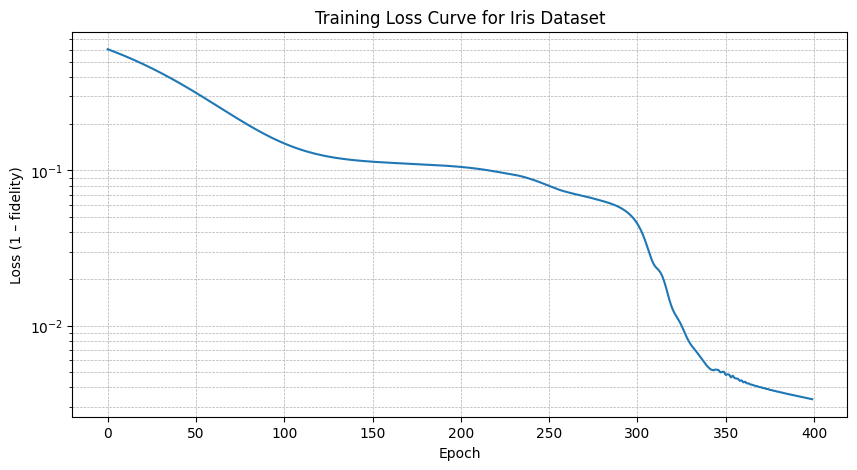

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for real-world dataset loading and preprocessing
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Iris dataset
NUM_STATES         = 3                                    # (g) Iris has 3 classes
WORK_QUBITS        = 2                                    # (n) Iris has 4 features, so we need 2^2=4 amplitudes
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # (x) ceil(log2(3)) = 2 ancilla qubits
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 3                                    # Batch size can be the number of states
DEPTH              = 10                                    # (l) Number of variational layers
LR                 = 1e-3
MAX_EPOCHS         = 400


# ───────────────────────────────────────────────────────────
# 2. DATASET (Iris Dataset Integration)
# ───────────────────────────────────────────────────────────
# REMOVED: The synthetic generate_data function is no longer needed.

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# --- Preprocess the data to create target quantum states ---

# 1. Scale features to be in a non-negative range (e.g., 0 to 1)
scaler = MinMaxScaler(feature_range=(0.1, 1)) # Use 0.1 to avoid zero vectors
X_scaled = scaler.fit_transform(X)

# 2. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 3. Normalize each mean vector to be a valid quantum state
# The L2 norm of the amplitude vector must be 1.
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("--- Target States from Iris Dataset ---")
for i, vec in enumerate(Y_targets_np):
    print(f"Class {i} ({iris.target_names[i]}): {np.round(vec, 3)}")
print("------------------------------------")


# 4. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))


# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {WIRES} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    """Circularly-entangled CRX layer."""
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    """A layer of RY rotations and a parameterized CRX entanglement block."""
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)

    def forward(self):
        return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])

    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)

    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Iris Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for state {i} ({iris.target_names[i]}): {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Iris Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


Madelon Dataset


--- Loading Madelon Dataset ---
Dataset shape: (2600, 500)
Original labels mapped to: [('2', tensor(0, requires_grad=True)), ('1', tensor(1, requires_grad=True))]
--- Applying PCA to reduce features to 128 ---

--- Target States from Madelon Dataset ---
Shape of target vectors: (2, 128)
-----------------------------------------
Using device: default.qubit with 8 wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.991729 | LR 0.001000
Epoch   20 | Avg Loss 0.973963 | LR 0.001000
Epoch   40 | Avg Loss 0.911514 | LR 0.001000
Epoch   60 | Avg Loss 0.727835 | LR 0.001000
Epoch   80 | Avg Loss 0.392359 | LR 0.001000
Epoch  100 | Avg Loss 0.115116 | LR 0.001000
Epoch  120 | Avg Loss 0.024404 | LR 0.001000
Epoch  140 | Avg Loss 0.008362 | LR 0.001000
Epoch  160 | Avg Loss 0.004453 | LR 0.001000
Epoch  180 | Avg Loss 0.003168 | LR 0.001000
Epoch  200 | Avg Loss 0.002678 | LR 0.001000
Epoch  220 | Avg Loss 0.002481 | LR 0.001000
Epoch  240 | Avg Loss 0.002401 | LR 0.001000
Epoch  260 | Avg Loss 0.002364 | LR 0.001000
Epoch  280 | Avg Loss 0.002344 | LR 0.001000
Epoch  300 | Avg Loss 0.002330 | LR 0.001000
Epoch  320 | Avg Loss 0.002318 | LR 0.001000
Epoch  340 | Avg Loss 0.002307 | LR 0.001000
Epoch  360 | Avg Loss 0.002297 | LR 0.001000
Epoch  380 | Avg Loss 0.002287 | LR 0.001000
Epoch  400 | Avg Loss 0.002278 | LR 0.001000
--- Training Complete ---

Training wall-time: 2491.5s


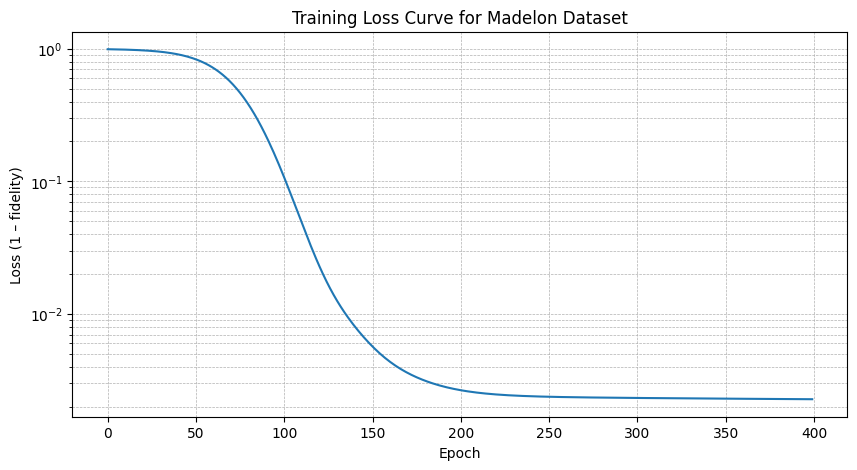

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for a more complex dataset and PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Madelon dataset after PCA
NUM_FEATURES       = 128                                  # Target number of features after PCA (a power of 2)
NUM_STATES         = 2                                    # Madelon is a binary classification problem
WORK_QUBITS        = int(math.log2(NUM_FEATURES))         # log2(128) = 7
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # ceil(log2(2)) = 1 ancilla qubit
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 2
DEPTH              = 10                                   # Increased depth for a harder problem
LR                 = 1e-3
MAX_EPOCHS         = 400


# ───────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────
# 2. DATASET (Madelon Dataset with PCA and Robust Labeling)
# ───────────────────────────────────────────────────────────
# ADDED: Import for pandas for robust data handling
import pandas as pd

# Load the Madelon dataset from OpenML
print("--- Loading Madelon Dataset ---")
madelon = fetch_openml('madelon', version=1, as_frame=True) # Load as a pandas DataFrame
X_df = madelon.data
y_series = madelon.target
print("Dataset shape:", X_df.shape)

# --- Preprocess the data ---

# SOLUTION: Use pandas.factorize() for robust label encoding.
# This converts any set of labels (e.g., '-1'/'1', 'A'/'B') into [0, 1, ...].
y, class_names = pd.factorize(y_series)
print(f"Original labels mapped to: {list(zip(class_names, np.unique(y)))}")

# 1. Apply PCA to reduce dimensionality from 500 to 128
print(f"--- Applying PCA to reduce features to {NUM_FEATURES} ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_pca = pca.fit_transform(X_df)

# 2. Scale features to be in a non-negative range
scaler = MinMaxScaler(feature_range=(0.1, 1))
X_scaled = scaler.fit_transform(X_pca)

# 3. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    # This line should now work correctly as `y` is guaranteed to contain 0 and 1.
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 4. Normalize each mean vector to be a valid quantum state
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Madelon Dataset ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# 5. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires): qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self): return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Madelon Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Madelon Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


--- Loading Madelon Dataset ---
Dataset shape: (2600, 500)
Original labels mapped to: [('2', tensor(0, requires_grad=True)), ('1', tensor(1, requires_grad=True))]
--- Applying PCA to reduce features to 256 ---

--- Target States from Madelon Dataset ---
Shape of target vectors: (2, 256)
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.998752 | LR 0.001000
Epoch   20 | Avg Loss 0.996142 | LR 0.001000
Epoch   40 | Avg Loss 0.985248 | LR 0.001000
Epoch   60 | Avg Loss 0.940347 | LR 0.001000
Epoch   80 | Avg Loss 0.796780 | LR 0.001000
Epoch  100 | Avg Loss 0.517079 | LR 0.001000
Epoch  120 | Avg Loss 0.236950 | LR 0.001000
Epoch  140 | Avg Loss 0.087545 | LR 0.001000
Epoch  160 | Avg Loss 0.033351 | LR 0.001000
Epoch  180 | Avg Loss 0.013976 | LR 0.001000
Epoch  200 | Avg Loss 0.006702 | LR 0.001000
Epoch  220 | Avg Loss 0.004187 | LR 0.001000
Epoch  240 | Avg Loss 0.003372 | LR 0.001000
Epoch  260 | Avg Loss 0.003096 | LR 0.001000
Epoch  280 | Avg Loss 0.002978 | LR 0.001000
Epoch  300 | Avg Loss 0.002909 | LR 0.001000
Epoch  320 | Avg Loss 0.002862 | LR 0.001000
Epoch  340 | Avg Loss 0.002828 | LR 0.001000
Epoch  360 | Avg Loss 0.002803 | LR 0.001000
Epoch  380 | Avg Loss 0.002785 | LR 0.001000
Epoch  400 | Avg Loss 0.002770 | LR 0.001000
--- Training Complete ---

Training wall-time: 2125.5s


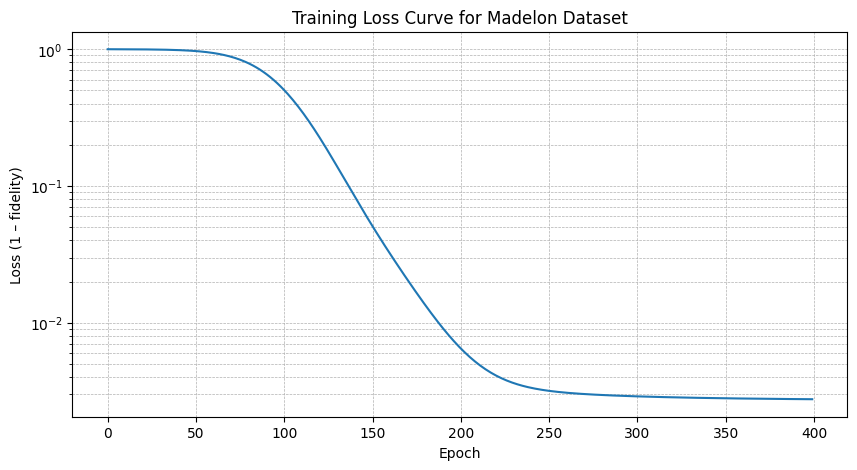

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for a more complex dataset and PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Madelon dataset after PCA
NUM_FEATURES       = 256                                  # Target number of features after PCA (a power of 2)
NUM_STATES         = 2                                    # Madelon is a binary classification problem
WORK_QUBITS        = int(math.log2(NUM_FEATURES))         # log2(128) = 7
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # ceil(log2(2)) = 1 ancilla qubit
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 2
DEPTH              = 8                                   # Increased depth for a harder problem
LR                 = 1e-3
MAX_EPOCHS         = 400


# ───────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────
# 2. DATASET (Madelon Dataset with PCA and Robust Labeling)
# ───────────────────────────────────────────────────────────
# ADDED: Import for pandas for robust data handling
import pandas as pd

# Load the Madelon dataset from OpenML
print("--- Loading Madelon Dataset ---")
madelon = fetch_openml('madelon', version=1, as_frame=True) # Load as a pandas DataFrame
X_df = madelon.data
y_series = madelon.target
print("Dataset shape:", X_df.shape)

# --- Preprocess the data ---

# SOLUTION: Use pandas.factorize() for robust label encoding.
# This converts any set of labels (e.g., '-1'/'1', 'A'/'B') into [0, 1, ...].
y, class_names = pd.factorize(y_series)
print(f"Original labels mapped to: {list(zip(class_names, np.unique(y)))}")

# 1. Apply PCA to reduce dimensionality from 500 to 128
print(f"--- Applying PCA to reduce features to {NUM_FEATURES} ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_pca = pca.fit_transform(X_df)

# 2. Scale features to be in a non-negative range
scaler = MinMaxScaler(feature_range=(0.1, 1))
X_scaled = scaler.fit_transform(X_pca)

# 3. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    # This line should now work correctly as `y` is guaranteed to contain 0 and 1.
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 4. Normalize each mean vector to be a valid quantum state
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Madelon Dataset ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# 5. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires): qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self): return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Madelon Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Madelon Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


--- Loading Madelon Dataset ---
Dataset shape: (2600, 500)
Original labels mapped to: [('2', tensor(0, requires_grad=True)), ('1', tensor(1, requires_grad=True))]
--- Applying PCA to reduce features to 256 ---

--- Target States from Madelon Dataset ---
Shape of target vectors: (2, 256)
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.997970 | LR 0.001000
Epoch   20 | Avg Loss 0.995390 | LR 0.001000
Epoch   40 | Avg Loss 0.987911 | LR 0.001000
Epoch   60 | Avg Loss 0.965305 | LR 0.001000
Epoch   80 | Avg Loss 0.902220 | LR 0.001000
Epoch  100 | Avg Loss 0.760726 | LR 0.001000
Epoch  120 | Avg Loss 0.534248 | LR 0.001000
Epoch  140 | Avg Loss 0.295625 | LR 0.001000
Epoch  160 | Avg Loss 0.132211 | LR 0.001000
Epoch  180 | Avg Loss 0.050960 | LR 0.001000
Epoch  200 | Avg Loss 0.018364 | LR 0.001000
Epoch  220 | Avg Loss 0.007382 | LR 0.001000
Epoch  240 | Avg Loss 0.004100 | LR 0.001000
Epoch  260 | Avg Loss 0.003175 | LR 0.001000
Epoch  280 | Avg Loss 0.002913 | LR 0.001000
Epoch  300 | Avg Loss 0.002831 | LR 0.001000
Epoch  320 | Avg Loss 0.002800 | LR 0.001000
Epoch  340 | Avg Loss 0.002786 | LR 0.001000
Epoch  360 | Avg Loss 0.002778 | LR 0.001000
Epoch  380 | Avg Loss 0.002773 | LR 0.001000
Epoch  400 | Avg Loss 0.002769 | LR 0.001000
--- Training Complete ---

Training wall-time: 1204.5s


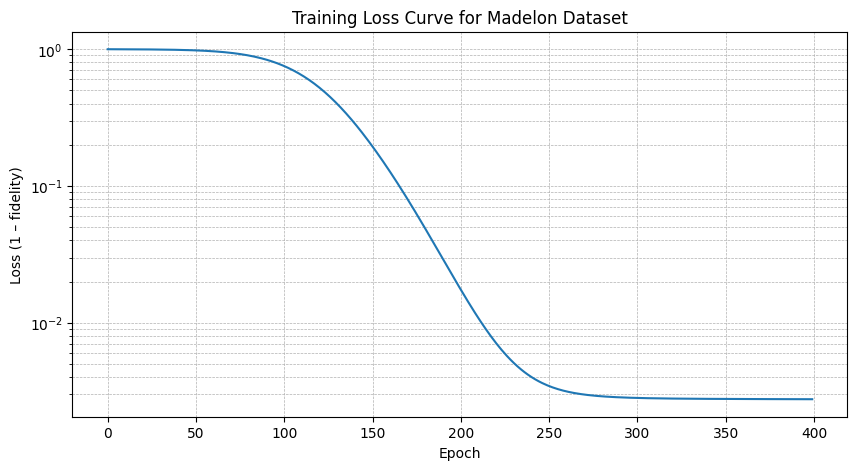

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for a more complex dataset and PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Madelon dataset after PCA
NUM_FEATURES       = 256                                  # Target number of features after PCA (a power of 2)
NUM_STATES         = 2                                    # Madelon is a binary classification problem
WORK_QUBITS        = int(math.log2(NUM_FEATURES))         # log2(128) = 7
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # ceil(log2(2)) = 1 ancilla qubit
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 2
DEPTH              = 6                                   # Increased depth for a harder problem
LR                 = 1e-3
MAX_EPOCHS         = 400


# ───────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────
# 2. DATASET (Madelon Dataset with PCA and Robust Labeling)
# ───────────────────────────────────────────────────────────
# ADDED: Import for pandas for robust data handling
import pandas as pd

# Load the Madelon dataset from OpenML
print("--- Loading Madelon Dataset ---")
madelon = fetch_openml('madelon', version=1, as_frame=True) # Load as a pandas DataFrame
X_df = madelon.data
y_series = madelon.target
print("Dataset shape:", X_df.shape)

# --- Preprocess the data ---

# SOLUTION: Use pandas.factorize() for robust label encoding.
# This converts any set of labels (e.g., '-1'/'1', 'A'/'B') into [0, 1, ...].
y, class_names = pd.factorize(y_series)
print(f"Original labels mapped to: {list(zip(class_names, np.unique(y)))}")

# 1. Apply PCA to reduce dimensionality from 500 to 128
print(f"--- Applying PCA to reduce features to {NUM_FEATURES} ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_pca = pca.fit_transform(X_df)

# 2. Scale features to be in a non-negative range
scaler = MinMaxScaler(feature_range=(0.1, 1))
X_scaled = scaler.fit_transform(X_pca)

# 3. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    # This line should now work correctly as `y` is guaranteed to contain 0 and 1.
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 4. Normalize each mean vector to be a valid quantum state
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Madelon Dataset ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# 5. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires): qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self): return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Madelon Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Madelon Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


--- Loading Madelon Dataset ---
Dataset shape: (2600, 500)
Original labels mapped to: [('2', tensor(0, requires_grad=True)), ('1', tensor(1, requires_grad=True))]
--- Applying PCA to reduce features to 256 ---

--- Target States from Madelon Dataset ---
Shape of target vectors: (2, 256)
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.997703 | LR 0.001000
Epoch   20 | Avg Loss 0.996034 | LR 0.001000
Epoch   40 | Avg Loss 0.992550 | LR 0.001000
Epoch   60 | Avg Loss 0.984900 | LR 0.001000
Epoch   80 | Avg Loss 0.967792 | LR 0.001000
Epoch  100 | Avg Loss 0.931248 | LR 0.001000
Epoch  120 | Avg Loss 0.860802 | LR 0.001000
Epoch  140 | Avg Loss 0.743809 | LR 0.001000
Epoch  160 | Avg Loss 0.582837 | LR 0.001000
Epoch  180 | Avg Loss 0.405423 | LR 0.001000
Epoch  200 | Avg Loss 0.250516 | LR 0.001000
Epoch  220 | Avg Loss 0.140532 | LR 0.001000
Epoch  240 | Avg Loss 0.074083 | LR 0.001000
Epoch  260 | Avg Loss 0.037942 | LR 0.001000
Epoch  280 | Avg Loss 0.019458 | LR 0.001000
Epoch  300 | Avg Loss 0.010404 | LR 0.001000
Epoch  320 | Avg Loss 0.006134 | LR 0.001000
Epoch  340 | Avg Loss 0.004191 | LR 0.001000
Epoch  360 | Avg Loss 0.003336 | LR 0.001000
Epoch  380 | Avg Loss 0.002971 | LR 0.001000
Epoch  400 | Avg Loss 0.002819 | LR 0.001000
--- Training Complete ---

Training wall-time: 619.6s



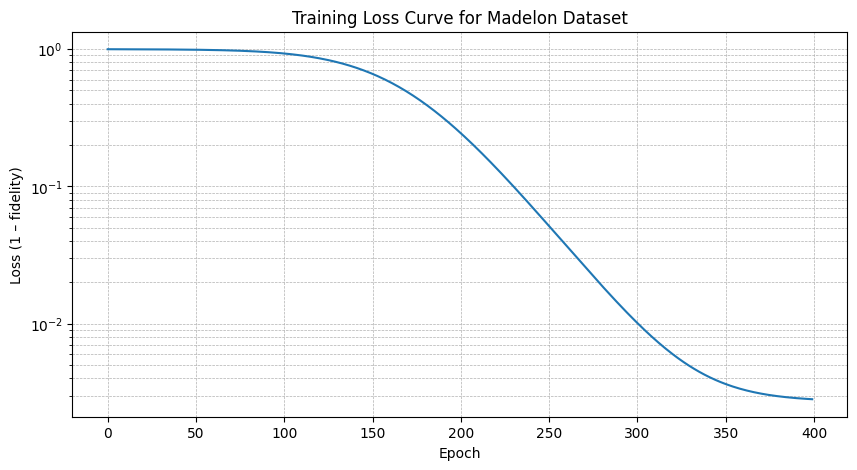

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for a more complex dataset and PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Madelon dataset after PCA
NUM_FEATURES       = 256                                  # Target number of features after PCA (a power of 2)
NUM_STATES         = 2                                    # Madelon is a binary classification problem
WORK_QUBITS        = int(math.log2(NUM_FEATURES))         # log2(128) = 7
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # ceil(log2(2)) = 1 ancilla qubit
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 2
DEPTH              = 4                                   # Increased depth for a harder problem
LR                 = 1e-3
MAX_EPOCHS         = 400


# ───────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────
# 2. DATASET (Madelon Dataset with PCA and Robust Labeling)
# ───────────────────────────────────────────────────────────
# ADDED: Import for pandas for robust data handling
import pandas as pd

# Load the Madelon dataset from OpenML
print("--- Loading Madelon Dataset ---")
madelon = fetch_openml('madelon', version=1, as_frame=True) # Load as a pandas DataFrame
X_df = madelon.data
y_series = madelon.target
print("Dataset shape:", X_df.shape)

# --- Preprocess the data ---

# SOLUTION: Use pandas.factorize() for robust label encoding.
# This converts any set of labels (e.g., '-1'/'1', 'A'/'B') into [0, 1, ...].
y, class_names = pd.factorize(y_series)
print(f"Original labels mapped to: {list(zip(class_names, np.unique(y)))}")

# 1. Apply PCA to reduce dimensionality from 500 to 128
print(f"--- Applying PCA to reduce features to {NUM_FEATURES} ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_pca = pca.fit_transform(X_df)

# 2. Scale features to be in a non-negative range
scaler = MinMaxScaler(feature_range=(0.1, 1))
X_scaled = scaler.fit_transform(X_pca)

# 3. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    # This line should now work correctly as `y` is guaranteed to contain 0 and 1.
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 4. Normalize each mean vector to be a valid quantum state
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Madelon Dataset ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# 5. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires): qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self): return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Madelon Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Madelon Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


--- Loading Madelon Dataset ---
Dataset shape: (2600, 500)
Original labels mapped to: [('2', tensor(0, requires_grad=True)), ('1', tensor(1, requires_grad=True))]
--- Applying PCA to reduce features to 256 ---

--- Target States from Madelon Dataset ---
Shape of target vectors: (2, 256)
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.995743 | LR 0.001000
Epoch   20 | Avg Loss 0.995139 | LR 0.001000
Epoch   40 | Avg Loss 0.994391 | LR 0.001000
Epoch   60 | Avg Loss 0.993487 | LR 0.001000
Epoch   80 | Avg Loss 0.992383 | LR 0.001000
Epoch  100 | Avg Loss 0.991028 | LR 0.001000
Epoch  120 | Avg Loss 0.989355 | LR 0.001000
Epoch  140 | Avg Loss 0.987283 | LR 0.001000
Epoch  160 | Avg Loss 0.984711 | LR 0.001000
Epoch  180 | Avg Loss 0.981512 | LR 0.001000
Epoch  200 | Avg Loss 0.977536 | LR 0.001000
Epoch  220 | Avg Loss 0.972602 | LR 0.001000
Epoch  240 | Avg Loss 0.966497 | LR 0.001000
Epoch  260 | Avg Loss 0.958981 | LR 0.001000
Epoch  280 | Avg Loss 0.949785 | LR 0.001000
Epoch  300 | Avg Loss 0.938622 | LR 0.001000
Epoch  320 | Avg Loss 0.925194 | LR 0.001000
Epoch  340 | Avg Loss 0.909208 | LR 0.001000
Epoch  360 | Avg Loss 0.890397 | LR 0.001000
Epoch  380 | Avg Loss 0.868539 | LR 0.001000
Epoch  400 | Avg Loss 0.843481 | LR 0.001000
Epoch  420 | Avg Loss 0.815157 | LR 0.001000
Epoch  440

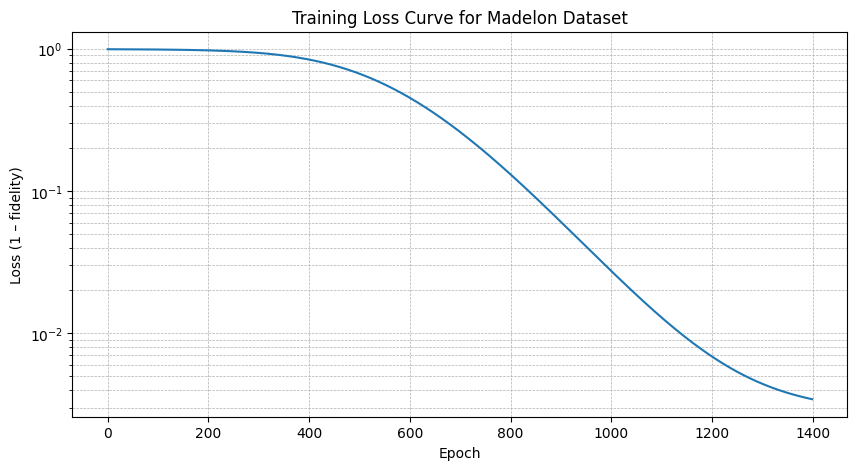

In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ADDED: Imports for a more complex dataset and PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION
# ───────────────────────────────────────────────────────────
SEED               = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CHANGED: Configuration updated for the Madelon dataset after PCA
NUM_FEATURES       = 256                                  # Target number of features after PCA (a power of 2)
NUM_STATES         = 2                                    # Madelon is a binary classification problem
WORK_QUBITS        = int(math.log2(NUM_FEATURES))         # log2(128) = 7
ANCILLA_QUBITS     = math.ceil(math.log2(NUM_STATES))     # ceil(log2(2)) = 1 ancilla qubit
TOTAL_QUBITS       = ANCILLA_QUBITS + WORK_QUBITS
WIRES              = list(range(TOTAL_QUBITS))
BATCH_SIZE         = 2
DEPTH              = 1                                   # Increased depth for a harder problem
LR                 = 1e-3
MAX_EPOCHS         = 1400


# ───────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────
# 2. DATASET (Madelon Dataset with PCA and Robust Labeling)
# ───────────────────────────────────────────────────────────
# ADDED: Import for pandas for robust data handling
import pandas as pd

# Load the Madelon dataset from OpenML
print("--- Loading Madelon Dataset ---")
madelon = fetch_openml('madelon', version=1, as_frame=True) # Load as a pandas DataFrame
X_df = madelon.data
y_series = madelon.target
print("Dataset shape:", X_df.shape)

# --- Preprocess the data ---

# SOLUTION: Use pandas.factorize() for robust label encoding.
# This converts any set of labels (e.g., '-1'/'1', 'A'/'B') into [0, 1, ...].
y, class_names = pd.factorize(y_series)
print(f"Original labels mapped to: {list(zip(class_names, np.unique(y)))}")

# 1. Apply PCA to reduce dimensionality from 500 to 128
print(f"--- Applying PCA to reduce features to {NUM_FEATURES} ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_pca = pca.fit_transform(X_df)

# 2. Scale features to be in a non-negative range
scaler = MinMaxScaler(feature_range=(0.1, 1))
X_scaled = scaler.fit_transform(X_pca)

# 3. For each class, calculate the mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    # This line should now work correctly as `y` is guaranteed to contain 0 and 1.
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)

# 4. Normalize each mean vector to be a valid quantum state
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Madelon Dataset ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# 5. Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Create the dataset and dataloader
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                     shuffle=True, generator=torch.Generator().manual_seed(SEED))



# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")


# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS (Thesis-Aligned)
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires): qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self): return self.theta, self.phi


# ───────────────────────────────────────────────────────────
# 5. QNODE
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    for wire in WIRES: qml.Hadamard(wires=wire)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS): qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    for wire in WIRES: qml.Hadamard(wires=wire)
    return qml.state()


# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)


# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()


# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses


# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Madelon Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8: pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history)
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (1 – fidelity)")
    plt.title("Training Loss Curve for Madelon Dataset")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()


In [ ]:
import math, random, time
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd

# 1. EXPERIMENT CONFIGURATION
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
NUM_FEATURES = 256
NUM_STATES = 2
WORK_QUBITS = int(math.log2(NUM_FEATURES))
TOTAL_QUBITS = WORK_QUBITS
WIRES = list(range(TOTAL_QUBITS))
BATCH_SIZE = 4
DEPTH = 1
LR = 1e-3
MAX_EPOCHS = 100

# 2. DATASET (Madelon with PCA)
madelon = fetch_openml('madelon', version=1, as_frame=True)
X_df = madelon.data
y_series = madelon.target
y, class_names = pd.factorize(y_series)
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_pca = pca.fit_transform(X_df)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_pca)
X_torch = torch.tensor(X_scaled, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_torch, y_torch)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))

# 3. QUANTUM DEVICE
dev = qml.device("default.qubit", wires=WIRES)

# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i+1)%num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# 5. QNODE for Classification
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(x, ry_thetas, crx_phis):
    norm = torch.linalg.norm(x)
    qml.AmplitudeEmbedding((x/norm).detach().numpy(), wires=WIRES, normalize=False)
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    return qml.expval(qml.PauliZ(0))  # Output for binary classification

# 6. HYBRID MODEL CONTAINER
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, x_batch):
        ry_thetas, crx_phis = self.get_params()
        out = [circuit(x, ry_thetas, crx_phis) for x in x_batch]
        out = torch.stack(out)
        return 0.5 * (1 - out)  # Map PauliZ to probability

# 7. TRAINING UTILITIES
def accuracy(preds, labels):
    return ((preds > 0.5).long() == labels).float().mean().item()

# 8. TRAINING LOOP
def train():
    model = QuantumModel()
    opt = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=30, min_lr=1e-6)
    losses, accs = [], []
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss, total_acc = 0, 0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            x_b, y_b = batch
            preds = model(x_b).squeeze()
            # loss = nn.BCELoss()(preds, y_b.float())
            loss = nn.BCELoss()(preds.float(), y_b.float())
            loss.backward()
            opt.step()
            total_loss += loss.item() * len(x_b)
            total_acc += accuracy(preds, y_b) * len(x_b)
        avg_loss = total_loss / len(dataset)
        avg_acc = total_acc / len(dataset)
        losses.append(avg_loss)
        accs.append(avg_acc)
        sched.step(avg_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | Acc {avg_acc:.3f} | LR {opt.param_groups[0]['lr']:.6f}")
    return model, losses, accs

# 9. MAIN EXECUTION
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history, acc_history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")
    # Optional: Add test split and evaluation for full benchmarking



Epoch    1 | Avg Loss 0.697898 | Acc 0.497 | LR 0.001000
Epoch   10 | Avg Loss 0.695030 | Acc 0.503 | LR 0.001000
Epoch   20 | Avg Loss 0.692409 | Acc 0.521 | LR 0.001000
Epoch   30 | Avg Loss 0.690141 | Acc 0.531 | LR 0.001000
Epoch   40 | Avg Loss 0.688933 | Acc 0.540 | LR 0.001000
Epoch   50 | Avg Loss 0.688507 | Acc 0.549 | LR 0.001000
Epoch   60 | Avg Loss 0.688286 | Acc 0.553 | LR 0.001000
Epoch   70 | Avg Loss 0.688136 | Acc 0.561 | LR 0.001000
Epoch   80 | Avg Loss 0.688032 | Acc 0.558 | LR 0.001000
Epoch   90 | Avg Loss 0.687969 | Acc 0.553 | LR 0.001000
Epoch  100 | Avg Loss 0.687949 | Acc 0.555 | LR 0.001000

Training wall-time: 6364.8s


--- Loading Covertype Dataset ---
Dataset shape: (581012, 54)
Original labels mapped to: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6)]
--- PCA to 54 (full feature rank) ---
--- Random projection to 256 ---


/usr/local/lib/python3.11/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (54 < 256).The dimensionality of the problem will not be reduced.
  warnings.warn(



--- Target States from Covertype ---
Shape of target vectors: (5, 256)
-----------------------------------------
Using device: default.qubit with 11 wires.

--- Starting Training (Covertype targets) ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.999227 | LR 0.001000
Epoch   20 | Avg Loss 0.907198 | LR 0.001000
Epoch   40 | Avg Loss 0.192684 | LR 0.001000
Epoch   60 | Avg Loss 0.089677 | LR 0.001000
Epoch   80 | Avg Loss 0.069065 | LR 0.001000
Epoch  100 | Avg Loss 0.068738 | LR 0.001000
Epoch  120 | Avg Loss 0.068050 | LR 0.000500
Epoch  140 | Avg Loss 0.087262 | LR 0.000500
Epoch  160 | Avg Loss 0.087184 | LR 0.000500
Epoch  180 | Avg Loss 0.085608 | LR 0.000500
Epoch  200 | Avg Loss 0.068357 | LR 0.000500
Epoch  220 | Avg Loss 0.086941 | LR 0.000500
Epoch  240 | Avg Loss 0.067656 | LR 0.000500
Epoch  260 | Avg Loss 0.086738 | LR 0.000500
Epoch  280 | Avg Loss 0.085093 | LR 0.000500
Epoch  300 | Avg Loss 0.076183 | LR 0.000500
Epoch  320 | Avg Loss 0.067786 | LR 0.000500
Epoch  340 | Avg Loss 0.084715 | LR 0.000500
Epoch  360 | Avg Loss 0.084559 | LR 0.000500
Epoch  380 | Avg Loss 0.066932 | LR 0.000500
Epoch  400 | Avg Loss 0.084317 | LR 0.000500
Epoch  420 | Avg Loss 0.085706 | LR 0.000500
Epoch  440

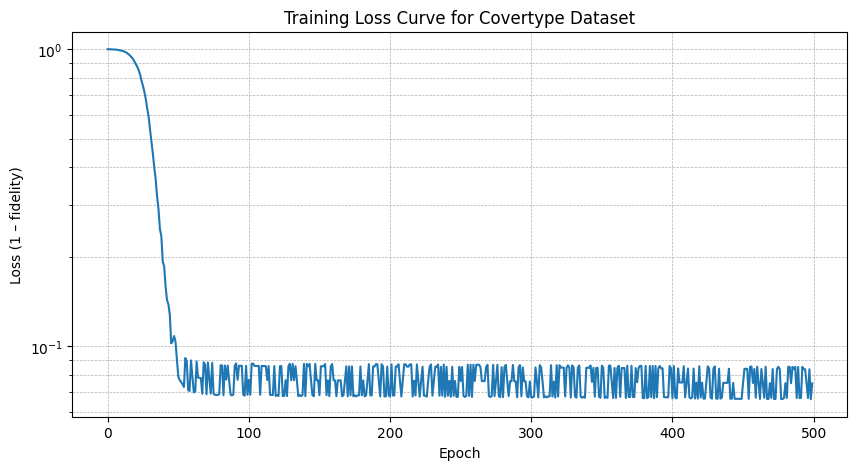

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# Extra sklearn utilities
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_covtype
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (Covertype, 7 classes)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 5                                 # Covertype has 7 classes
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = math.ceil(math.log2(NUM_STATES))  # 7 -> 3 ancilla
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 11 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 2
DEPTH               = 8
LR                  = 1e-3
MAX_EPOCHS          = 500  # 1,400 works too; set smaller for quick checks

# ───────────────────────────────────────────────────────────
# 2. DATASET (Covertype with PCA->54 then RandomProjection->256)
# ───────────────────────────────────────────────────────────
print("--- Loading Covertype Dataset ---")
cov = fetch_covtype(as_frame=True)  # X: (581012,54), y: {1..7}
X_df = cov.data
y_series = cov.target
print("Dataset shape:", X_df.shape)

# Remap labels 1..7 -> 0..6
y = y_series.to_numpy().astype(int) - 1
print(f"Original labels mapped to: {list(zip(range(1,8), range(0,7)))}")

# Stage 1: PCA to full rank (54) for denoising/whitening
print("--- PCA to 54 (full feature rank) ---")
pca_54 = PCA(n_components=54, random_state=SEED)
X_54 = pca_54.fit_transform(X_df.values)

# Stage 2: Random projection to 256 to match 2^8 amplitudes
print(f"--- Random projection to {NUM_FEATURES} ---")
rp = GaussianRandomProjection(n_components=NUM_FEATURES, random_state=SEED)
X_proj = rp.fit_transform(X_54)  # shape: (N,256)

# Scale features to non-negative range [0.1, 1.0] (consistent with your pipeline)
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# For each class, compute mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)  # shape (7,256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Covertype ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Tiny dataset of 7 class states, as in your original design
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as basis state
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    # Create superposition on all wires (same as your design)
    for wire in WIRES:
        qml.Hadamard(wires=wire)
    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)
    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (Covertype targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Covertype Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for Covertype Dataset")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass


--- Loading Covertype Dataset ---
Dataset shape: (581012, 54)
Original labels mapped to: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6)]
--- PCA to 54 (full feature rank) ---
--- Random projection to 256 ---


/usr/local/lib/python3.11/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (54 < 256).The dimensionality of the problem will not be reduced.
  warnings.warn(



--- Target States from Covertype ---
Shape of target vectors: (4, 256)
-----------------------------------------
Using device: default.qubit with 10 wires.

--- Starting Training (Covertype targets) ---


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.997809 | LR 0.005000
Epoch   20 | Avg Loss 0.132257 | LR 0.005000
Epoch   40 | Avg Loss 0.097541 | LR 0.005000
Epoch   60 | Avg Loss 0.096117 | LR 0.005000
Epoch   80 | Avg Loss 0.095575 | LR 0.005000
Epoch  100 | Avg Loss 0.094716 | LR 0.005000
Epoch  120 | Avg Loss 0.057136 | LR 0.005000
Epoch  140 | Avg Loss 0.093607 | LR 0.005000
Epoch  160 | Avg Loss 0.093509 | LR 0.002500
Epoch  180 | Avg Loss 0.090251 | LR 0.002500
Epoch  200 | Avg Loss 0.090172 | LR 0.002500
--- Training Complete ---

Training wall-time: 3933.7s

── Final Model Fidelities on Covertype Target States ──
Fidelity for class 0: 0.975488
Fidelity for class 1: 0.979174
Fidelity for class 2: 0.878334
Fidelity for class 3: 0.869487
─────────────────────────
Average fidelity: 0.925621
Minimum fidelity: 0.869487


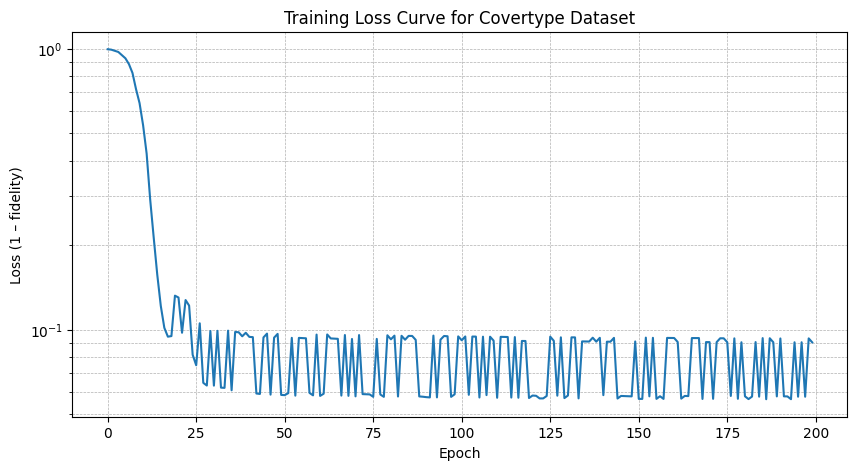

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# Extra sklearn utilities
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_covtype
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (Covertype, 7 classes)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 4                                 # Covertype has 7 classes
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = math.ceil(math.log2(NUM_STATES))  # 7 -> 3 ancilla
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 11 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 3
DEPTH               = 10
LR                  = 5e-3
MAX_EPOCHS          = 200  # 1,400 works too; set smaller for quick checks

# ───────────────────────────────────────────────────────────
# 2. DATASET (Covertype with PCA->54 then RandomProjection->256)
# ───────────────────────────────────────────────────────────
print("--- Loading Covertype Dataset ---")
cov = fetch_covtype(as_frame=True)  # X: (581012,54), y: {1..7}
X_df = cov.data
y_series = cov.target
print("Dataset shape:", X_df.shape)

# Remap labels 1..7 -> 0..6
y = y_series.to_numpy().astype(int) - 1
print(f"Original labels mapped to: {list(zip(range(1,8), range(0,7)))}")

# Stage 1: PCA to full rank (54) for denoising/whitening
print("--- PCA to 54 (full feature rank) ---")
pca_54 = PCA(n_components=54, random_state=SEED)
X_54 = pca_54.fit_transform(X_df.values)

# Stage 2: Random projection to 256 to match 2^8 amplitudes
print(f"--- Random projection to {NUM_FEATURES} ---")
rp = GaussianRandomProjection(n_components=NUM_FEATURES, random_state=SEED)
X_proj = rp.fit_transform(X_54)  # shape: (N,256)

# Scale features to non-negative range [0.1, 1.0] (consistent with your pipeline)
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# For each class, compute mean feature vector
mean_vectors = []
for i in range(NUM_STATES):
    mean_vec = X_scaled[y == i].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)  # shape (7,256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from Covertype ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Tiny dataset of 7 class states, as in your original design
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as basis state
    qml.BasisState(state_idx, wires=range(ANCILLA_QUBITS))
    # Create superposition on all wires (same as your design)
    for wire in WIRES:
        qml.Hadamard(wires=wire)
    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)
    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)
    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (Covertype targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on Covertype Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for Covertype Dataset")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass


--- Loading MNIST Dataset (Class 0 only) ---


100%|██████████| 9.91M/9.91M [00:00<00:00, 51.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.79MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.49MB/s]


Selected 100 images of class 0
Original image features shape: (100, 784)
--- PCA for dimensionality reduction ---
After PCA: (100, 100)
--- Random projection to 256 ---

--- Target State from MNIST Class 0 ---
Shape of target vector: (256,)
Target vector norm: 1.000000
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training (MNIST Class 0 target) ---


/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (100 < 256).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.998733 | LR 0.005000
Epoch   20 | Avg Loss 0.767368 | LR 0.005000
Epoch   40 | Avg Loss 0.053699 | LR 0.005000
Epoch   60 | Avg Loss 0.015526 | LR 0.005000
Epoch   80 | Avg Loss 0.010784 | LR 0.005000
Epoch  100 | Avg Loss 0.009784 | LR 0.005000
Epoch  120 | Avg Loss 0.009603 | LR 0.005000
Epoch  140 | Avg Loss 0.009492 | LR 0.005000
Epoch  160 | Avg Loss 0.009407 | LR 0.005000
Epoch  180 | Avg Loss 0.009334 | LR 0.005000
Epoch  200 | Avg Loss 0.009265 | LR 0.005000
--- Training Complete ---

Training wall-time: 765.2s

── Final Model Fidelity on MNIST Class 0 Target State ──
Fidelity for MNIST class 0: 0.990738
─────────────────────────


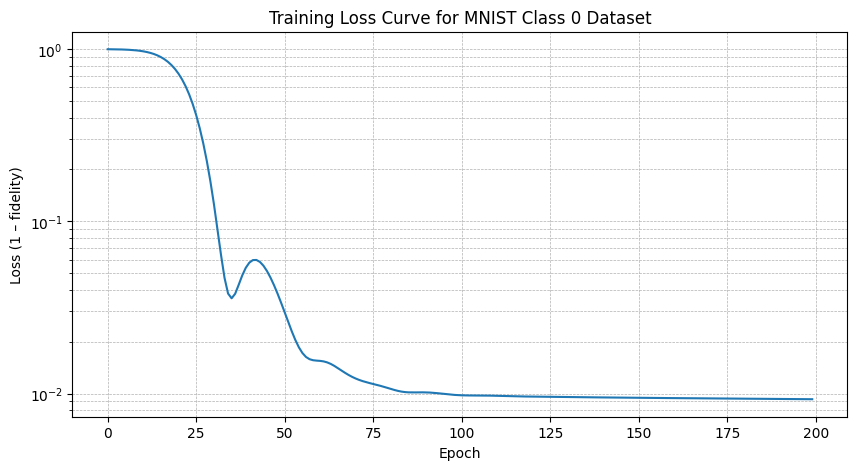

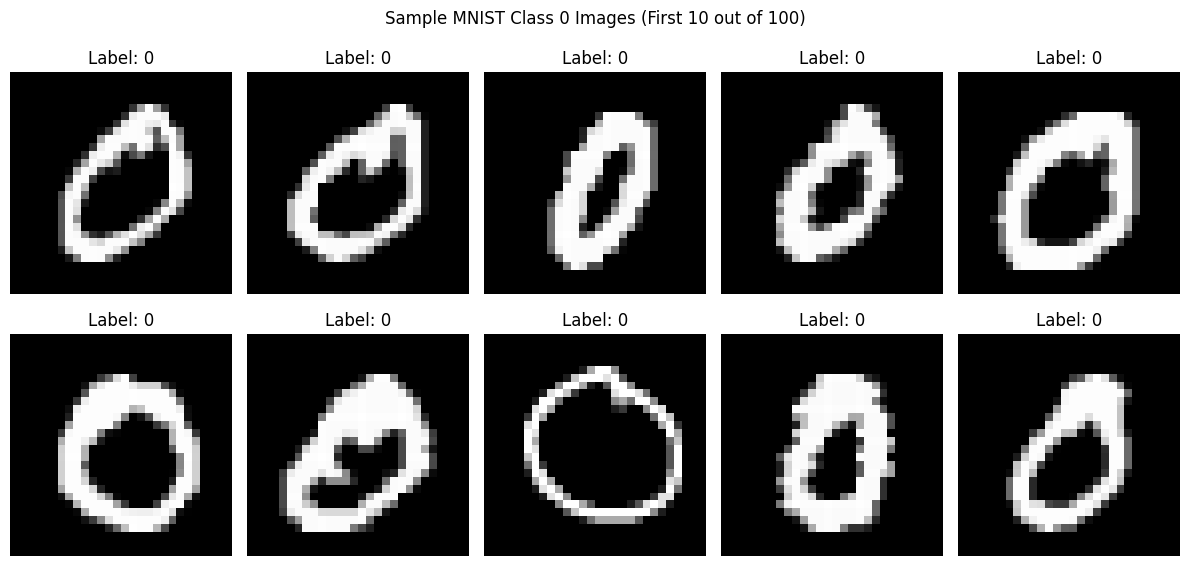

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

# Extra sklearn utilities
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, Class 0 only)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 1                                 # Only class 0
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = max(1, math.ceil(math.log2(NUM_STATES)))  # At least 1 ancilla qubit
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 9 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 1                                 # Only 1 class now
DEPTH               = 10
LR                  = 5e-3
MAX_EPOCHS          = 200

# ───────────────────────────────────────────────────────────
# 2. DATASET (MNIST with 100 images of class 0)
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset (Class 0 only) ---")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter out 100 samples of class '0'
indices_class_0 = [i for i, (_, label) in enumerate(mnist_dataset) if label == 0][:100]
subset_class_0 = Subset(mnist_dataset, indices_class_0)

print(f"Selected {len(subset_class_0)} images of class 0")

# Convert images to feature vectors
X_images = []
for i in range(len(subset_class_0)):
    image, label = subset_class_0[i]
    # Flatten 28x28 image to 784 features
    image_flat = image.view(-1).numpy()
    X_images.append(image_flat)

X_images = np.array(X_images)  # Shape: (100, 784)
print(f"Original image features shape: {X_images.shape}")

# Stage 1: PCA to reduce dimensionality while preserving information
print("--- PCA for dimensionality reduction ---")
# Use PCA to reduce from 784 to a reasonable intermediate dimension
pca_intermediate = PCA(n_components=min(100, X_images.shape[1]), random_state=SEED)
X_pca = pca_intermediate.fit_transform(X_images)
print(f"After PCA: {X_pca.shape}")

# Stage 2: Random projection to 256 to match 2^8 amplitudes
print(f"--- Random projection to {NUM_FEATURES} ---")
rp = GaussianRandomProjection(n_components=NUM_FEATURES, random_state=SEED)
X_proj = rp.fit_transform(X_pca)  # shape: (100, 256)

# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Compute mean feature vector for class 0
mean_vector = X_scaled.mean(axis=0)  # Shape: (256,)

# Normalize to form valid target quantum state
norm = np.linalg.norm(mean_vector)
Y_target_np = mean_vector / norm

print("\n--- Target State from MNIST Class 0 ---")
print(f"Shape of target vector: {Y_target_np.shape}")
print(f"Target vector norm: {np.linalg.norm(Y_target_np):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_target_np.reshape(1, -1), dtype=torch.complex128)  # Shape: (1, 256)
state_indices = torch.tensor([0], dtype=torch.int64)  # Only state index 0

# Dataset of 1 class state
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as basis state
    if ANCILLA_QUBITS > 0:
        # Convert state_idx to binary representation for ancilla qubits
        binary_state = [(state_idx >> i) & 1 for i in range(ANCILLA_QUBITS)]
        qml.BasisState(binary_state, wires=range(ANCILLA_QUBITS))

    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST Class 0 target) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelity on MNIST Class 0 Target State ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        target_state = Y_targets[0]
        state_idx = 0
        full_psi = circuit(ry_thetas, crx_phis, state_idx)
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_psi[offset:end]
        norm = torch.linalg.norm(pred)
        if norm > 1e-8:
            pred = pred / norm
        fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
        print(f"Fidelity for MNIST class 0: {fid.item():.6f}")

    print("─────────────────────────")

    # Plotting
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST Class 0 Dataset")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: Display some sample images from the class 0 dataset
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        for i in range(10):
            image, label = subset_class_0[i]
            row, col = i // 5, i % 5
            axes[row, col].imshow(image.squeeze(), cmap='gray')
            axes[row, col].set_title(f'Label: {label}')
            axes[row, col].axis('off')
        plt.suptitle('Sample MNIST Class 0 Images (First 10 out of 100)')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass


In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

# Extra sklearn utilities
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, Classes 0 and 1)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 2                                 # Classes 0 and 1
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = math.ceil(math.log2(NUM_STATES))  # 2 -> 1 ancilla qubit
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 9 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 2                                 # Can handle both classes
DEPTH               = 10
LR                  = 5e-3
MAX_EPOCHS          = 300

# ───────────────────────────────────────────────────────────
# 2. DATASET (MNIST with 50 images each of classes 0 and 1)
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset (Classes 0 and 1) ---")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter out 50 samples each of classes '0' and '1'
indices_class_0 = [i for i, (_, label) in enumerate(mnist_dataset) if label == 0][:512]
indices_class_1 = [i for i, (_, label) in enumerate(mnist_dataset) if label == 1][:512]

# Combine indices
selected_indices = indices_class_0 + indices_class_1
subset_selected = Subset(mnist_dataset, selected_indices)

print(f"Selected {len(indices_class_0)} images of class 0")
print(f"Selected {len(indices_class_1)} images of class 1")
print(f"Total selected images: {len(subset_selected)}")

# Convert images to feature vectors and separate by class
X_class_0 = []
X_class_1 = []

for i in range(len(subset_selected)):
    image, label = subset_selected[i]
    # Flatten 28x28 image to 784 features
    image_flat = image.view(-1).numpy()
    if label == 0:
        X_class_0.append(image_flat)
    elif label == 1:
        X_class_1.append(image_flat)

X_class_0 = np.array(X_class_0)  # Shape: (50, 784)
X_class_1 = np.array(X_class_1)  # Shape: (50, 784)
X_combined = np.vstack([X_class_0, X_class_1])  # Shape: (100, 784)

print(f"Class 0 features shape: {X_class_0.shape}")
print(f"Class 1 features shape: {X_class_1.shape}")
print(f"Combined features shape: {X_combined.shape}")

# Stage 1: PCA to reduce dimensionality while preserving information
print("--- PCA for dimensionality reduction ---")
# Use PCA to reduce from 784 to a reasonable intermediate dimension
pca_intermediate = PCA(n_components=min(100, X_combined.shape[1]), random_state=SEED)
X_pca = pca_intermediate.fit_transform(X_combined)
print(f"After PCA: {X_pca.shape}")

# Split back into classes after PCA
X_pca_class_0 = X_pca[:50]  # First 50 samples
X_pca_class_1 = X_pca[50:]  # Next 50 samples

# Stage 2: Random projection to 256 to match 2^8 amplitudes
print(f"--- Random projection to {NUM_FEATURES} ---")
rp = GaussianRandomProjection(n_components=NUM_FEATURES, random_state=SEED)
X_proj = rp.fit_transform(X_pca)  # shape: (100, 256)

# Split projected features by class
X_proj_class_0 = X_proj[:50]  # First 50 samples (class 0)
X_proj_class_1 = X_proj[50:]  # Next 50 samples (class 1)

# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Split scaled features by class
X_scaled_class_0 = X_scaled[:50]
X_scaled_class_1 = X_scaled[50:]

# Compute mean feature vectors for each class
mean_vector_0 = X_scaled_class_0.mean(axis=0)  # Shape: (256,)
mean_vector_1 = X_scaled_class_1.mean(axis=0)  # Shape: (256,)

# Combine mean vectors
mean_vectors = np.array([mean_vector_0, mean_vector_1])  # Shape: (2, 256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from MNIST Classes 0 and 1 ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print(f"Class 0 target vector norm: {np.linalg.norm(Y_targets_np[0]):.6f}")
print(f"Class 1 target vector norm: {np.linalg.norm(Y_targets_np[1]):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)  # [0, 1]

# Dataset of 2 class states
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as basis state
    binary_state = [(state_idx >> i) & 1 for i in range(ANCILLA_QUBITS)]
    qml.BasisState(binary_state, wires=range(ANCILLA_QUBITS))

    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST Classes 0 and 1 targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on MNIST Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for MNIST class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting training curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST Classes 0 and 1")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: Display sample images from both classes
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))

        # Display 10 samples from class 0
        for i in range(10):
            image, label = subset_selected[i]  # First 50 are class 0
            axes[0, i].imshow(image.squeeze(), cmap='gray')
            axes[0, i].set_title(f'Class {label}')
            axes[0, i].axis('off')

        # Display 10 samples from class 1
        for i in range(10):
            image, label = subset_selected[i + 50]  # Next 50 are class 1
            axes[1, i].imshow(image.squeeze(), cmap='gray')
            axes[1, i].set_title(f'Class {label}')
            axes[1, i].axis('off')

        plt.suptitle('Sample MNIST Images: Class 0 (top) and Class 1 (bottom)')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    # Compute and display class separation metrics
    try:
        # Calculate similarity between the two target states
        state_0 = Y_targets[0].numpy()
        state_1 = Y_targets[1].numpy()

        # Inner product (overlap)
        overlap = np.abs(np.vdot(state_0, state_1))**2
        print(f"\nTarget state overlap (class 0 vs class 1): {overlap:.6f}")
        print(f"Target state separation (1 - overlap): {1 - overlap:.6f}")

        # Compute fidelity between predicted states
        with torch.no_grad():
            pred_0 = circuit(ry_thetas, crx_phis, 0)[0:256]
            pred_1 = circuit(ry_thetas, crx_phis, 1)[256:512]

            pred_0 = pred_0 / torch.linalg.norm(pred_0)
            pred_1 = pred_1 / torch.linalg.norm(pred_1)

            pred_overlap = torch.abs(torch.vdot(pred_0, pred_1))**2
            print(f"Predicted state overlap: {pred_overlap.item():.6f}")
            print(f"Predicted state separation: {1 - pred_overlap.item():.6f}")

    except Exception as e:
        print(f"Could not compute separation metrics: {e}")


--- Loading MNIST Dataset (Classes 0 and 1) ---


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.73MB/s]


Selected 512 images of class 0
Selected 512 images of class 1
Total selected images: 1024
Class 0 features shape: (512, 784)
Class 1 features shape: (512, 784)
Combined features shape: (1024, 784)
--- PCA for dimensionality reduction ---
After PCA: (1024, 100)
--- Random projection to 256 ---

--- Target States from MNIST Classes 0 and 1 ---
Shape of target vectors: (2, 256)
Class 0 target vector norm: 1.000000
Class 1 target vector norm: 1.000000
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training (MNIST Classes 0 and 1 targets) ---


/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (100 < 256).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.998911 | LR 0.005000
Epoch   20 | Avg Loss 0.761948 | LR 0.005000


KeyboardInterrupt: 

--- Loading MNIST Dataset (Classes: [0, 1, 2, 3] ) ---
Selection summary:
  Class 0: 256 images
  Class 1: 256 images
  Class 2: 256 images
  Class 3: 256 images
Total selected images: 1024
Original image features shape: (1024, 784)
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3}
--- PCA reduction to 256 components ---

--- Target States from MNIST ---
Shape of target vectors: (4, 256)
  Class 0 (state 0) norm: 1.000000
  Class 1 (state 1) norm: 1.000000
  Class 2 (state 2) norm: 1.000000
  Class 3 (state 3) norm: 1.000000
-----------------------------------------
Using device: default.qubit with 10 wires.

--- Starting Training (MNIST 4-class targets) ---


/usr/local/lib/python3.12/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.993750 | LR 0.005000
Epoch   20 | Avg Loss 0.520691 | LR 0.005000
Epoch   40 | Avg Loss 0.044032 | LR 0.005000
Epoch   60 | Avg Loss 0.010046 | LR 0.005000
Epoch   80 | Avg Loss 0.006706 | LR 0.005000
Epoch  100 | Avg Loss 0.006028 | LR 0.005000
Epoch  120 | Avg Loss 0.005907 | LR 0.005000
Epoch  140 | Avg Loss 0.005873 | LR 0.005000
--- Training Complete ---

Training wall-time: 3112.8s

── Final Model Fidelities on MNIST Target States ──
Fidelity for MNIST class 0 (state 0): 0.994381
Fidelity for MNIST class 1 (state 1): 0.993076
Fidelity for MNIST class 2 (state 2): 0.994647
Fidelity for MNIST class 3 (state 3): 0.994455
─────────────────────────
Average fidelity: 0.994140
Minimum fidelity: 0.993076


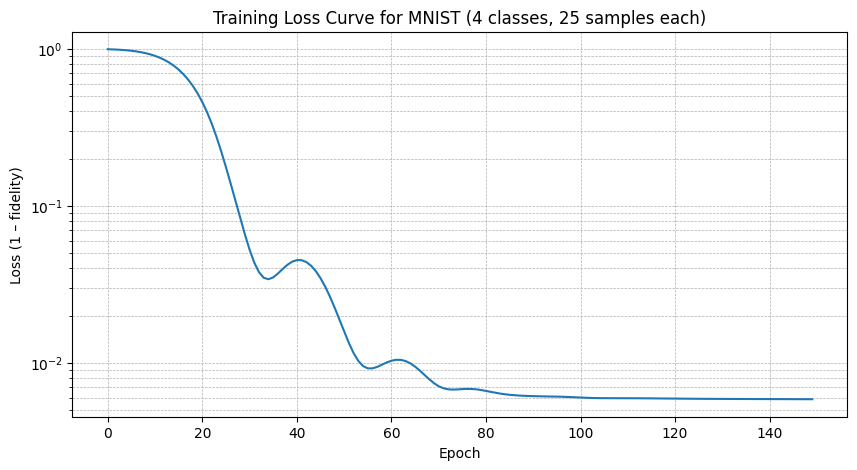

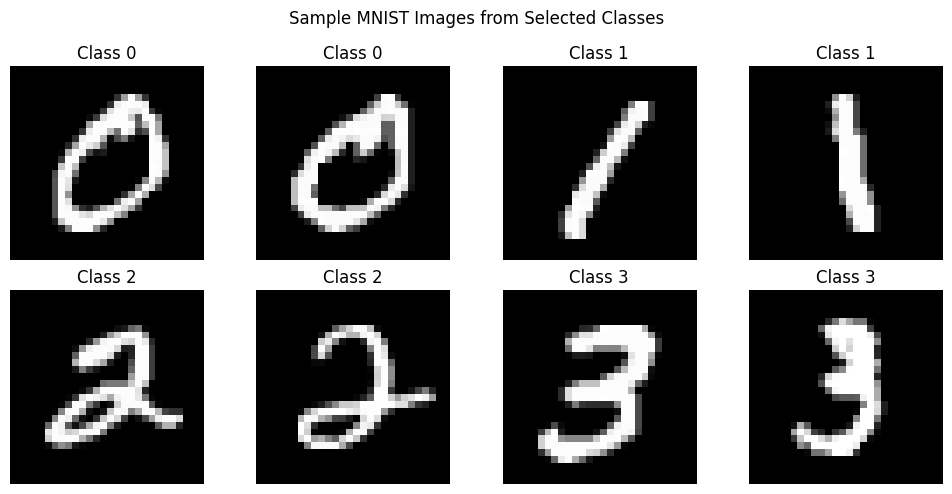

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, 4 classes, 25 samples each)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 4                                 # Four classes
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = math.ceil(math.log2(NUM_STATES))  # 4 -> 2 ancilla qubits
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 10 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 4
DEPTH               = 10
LR                  = 5e-3
MAX_EPOCHS          = 150

CLASSES             = [0, 1, 2, 3]                      # Choose any 4 classes from 0..9
SAMPLES_PER_CLASS   = 256

# ───────────────────────────────────────────────────────────
# 2. DATASET (MNIST with 25 images each of 4 classes)
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset (Classes:", CLASSES, ") ---")

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Collect indices for each target class
selected_indices_by_class = {c: [] for c in CLASSES}
for i, (_, label) in enumerate(mnist_dataset):
    if label in selected_indices_by_class and len(selected_indices_by_class[label]) < SAMPLES_PER_CLASS:
        selected_indices_by_class[label].append(i)
    if all(len(v) >= SAMPLES_PER_CLASS for v in selected_indices_by_class.values()):
        break

# Combine in the order of CLASSES
selected_indices = []
for c in CLASSES:
    assert len(selected_indices_by_class[c]) == SAMPLES_PER_CLASS, f"Not enough samples for class {c}"
    selected_indices.extend(selected_indices_by_class[c])

subset_selected = Subset(mnist_dataset, selected_indices)

print("Selection summary:")
for c in CLASSES:
    print(f"  Class {c}: {len(selected_indices_by_class[c])} images")
print(f"Total selected images: {len(subset_selected)}")

# Build feature matrix X and labels y
X_list, y_list = [], []
for i in range(len(subset_selected)):
    image, label = subset_selected[i]
    image_flat = image.view(-1).numpy()  # 784 vector
    X_list.append(image_flat)
    y_list.append(label)

X = np.array(X_list)  # Shape: (100, 784)
y = np.array(y_list)

print(f"Original image features shape: {X.shape}")

# Remap labels to contiguous states {0,1,2,3} according to CLASSES order
label_to_state = {c: i for i, c in enumerate(CLASSES)}
y_mapped = np.array([label_to_state[int(lbl)] for lbl in y])
print("Label mapping:", label_to_state)

# Stage 1: PCA directly to 256 components (matching 8 qubits)
print(f"--- PCA reduction to {NUM_FEATURES} components ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_proj = pca.fit_transform(X)  # shape


# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Compute mean feature vector for each mapped class
mean_vectors = []
for state_idx in range(NUM_STATES):
    mean_vec = X_scaled[y_mapped == state_idx].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)  # shape: (4, 256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from MNIST ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
for i, c in enumerate(CLASSES):
    print(f"  Class {c} (state {i}) norm: {np.linalg.norm(Y_targets_np[i]):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Tiny dataset of 4 class states
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as binary basis state
    binary_state = [(state_idx >> i) & 1 for i in range(ANCILLA_QUBITS)]
    qml.BasisState(binary_state, wires=range(ANCILLA_QUBITS))

    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST 4-class targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on MNIST Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            mapped_label = CLASSES[i]
            print(f"Fidelity for MNIST class {mapped_label} (state {i}): {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting training curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST (4 classes, 25 samples each)")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: visualize a few samples per class (8 images total)
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 4, figsize=(10, 5))
        idx = 0
        for ci, c in enumerate(CLASSES):
            # show two samples from each class
            for k in range(2):
                img, lbl = subset_selected[ci*SAMPLES_PER_CLASS + k]
                axes[idx // 4, idx % 4].imshow(img.squeeze(), cmap='gray')
                axes[idx // 4, idx % 4].set_title(f'Class {lbl}')
                axes[idx // 4, idx % 4].axis('off')
                idx += 1
        plt.suptitle('Sample MNIST Images from Selected Classes')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass


--- Loading MNIST Dataset (Classes:  [0, 1] ) ---
Selection summary:
  Class 0: 512 images
  Class 1: 512 images
Total selected images: 1024
Original image features shape: (1024, 784)
Label mapping: {0: 0, 1: 1}
--- PCA reduction to 256 components ---

--- Target States from MNIST ---
Shape of target vectors: (2, 256)
  Class 0 (state 0) norm: 1.000000
  Class 1 (state 1) norm: 1.000000
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training (MNIST 2-class targets) ---


/usr/local/lib/python3.12/dist-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch    1 | Avg Loss 0.998063 | LR 0.005000
Epoch   20 | Avg Loss 0.763679 | LR 0.005000
Epoch   40 | Avg Loss 0.048730 | LR 0.005000
Epoch   60 | Avg Loss 0.012658 | LR 0.005000
Epoch   80 | Avg Loss 0.007991 | LR 0.005000
Epoch  100 | Avg Loss 0.007405 | LR 0.005000
Epoch  120 | Avg Loss 0.007316 | LR 0.005000
Epoch  140 | Avg Loss 0.007287 | LR 0.005000
--- Training Complete ---

Training wall-time: 1194.2s

── Final Model Fidelities on MNIST Target States ──
Fidelity for MNIST class 0 (state 0): 0.993547
Fidelity for MNIST class 1 (state 1): 0.991902
─────────────────────────
Average fidelity: 0.992724
Minimum fidelity: 0.991902


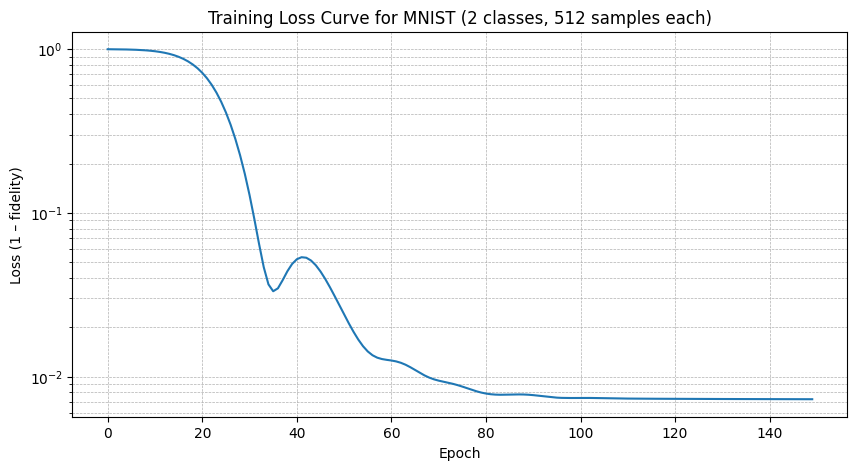

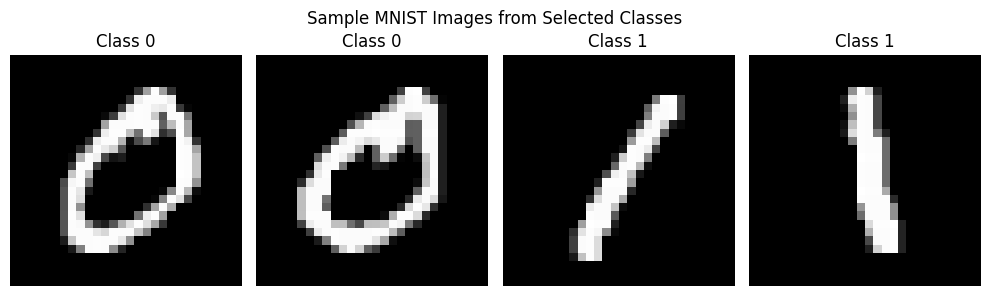

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, 2 classes, 512 samples each)
# ───────────────────────────────────────────────────────────
SEED                 = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES         = 256                                # 2^8 amplitudes -> 8 data qubits
NUM_STATES           = 2                                  # Two classes (e.g., 0,1)
WORK_QUBITS          = int(math.log2(NUM_FEATURES))       # 256 -> 8
ANCILLA_QUBITS       = math.ceil(math.log2(NUM_STATES))   # 2 -> 1 ancilla qubit
TOTAL_QUBITS         = ANCILLA_QUBITS + WORK_QUBITS       # 9 total wires
WIRES                = list(range(TOTAL_QUBITS))
BATCH_SIZE           = 2
DEPTH                = 10
LR                   = 5e-3
MAX_EPOCHS           = 150

CLASSES              = [0, 1]
SAMPLES_PER_CLASS    = 512

# ───────────────────────────────────────────────────────────
# 2. DATASET
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset (Classes: ", CLASSES, ") ---")

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Collect indices
selected_indices_by_class = {c: [] for c in CLASSES}
for i, (_, label) in enumerate(mnist_dataset):
    if label in selected_indices_by_class and len(selected_indices_by_class[label]) < SAMPLES_PER_CLASS:
        selected_indices_by_class[label].append(i)
    if all(len(v) >= SAMPLES_PER_CLASS for v in selected_indices_by_class.values()):
        break

# Combine in class order
selected_indices = []
for c in CLASSES:
    assert len(selected_indices_by_class[c]) == SAMPLES_PER_CLASS, f"Not enough samples collected for class {c}"
    selected_indices.extend(selected_indices_by_class[c])

subset_selected = Subset(mnist_dataset, selected_indices)

print("Selection summary:")
for c in CLASSES:
    print(f"  Class {c}: {len(selected_indices_by_class[c])} images")
print(f"Total selected images: {len(subset_selected)}")

# Build feature matrix and class labels
X_list = []
y_list = []
for i in range(len(subset_selected)):
    image, label = subset_selected[i]
    image_flat = image.view(-1).numpy()  # 784
    X_list.append(image_flat)
    y_list.append(label)

X = np.array(X_list)   # (1024, 784)
y = np.array(y_list)   # labels in {0,1}

print(f"Original image features shape: {X.shape}")

# Remap labels to 0..NUM_STATES-1 in the order of CLASSES
label_to_state = {c: i for i, c in enumerate(CLASSES)}
y_mapped = np.array([label_to_state[int(lbl)] for lbl in y])
print("Label mapping:", label_to_state)

# Stage: PCA directly to 256 components (matching 8 qubits)
print(f"--- PCA reduction to {NUM_FEATURES} components ---")
pca_components = min(NUM_FEATURES, X.shape[0], X.shape[1])  # guard
pca = PCA(n_components=pca_components, random_state=SEED)
X_proj = pca.fit_transform(X)  # shape should be (1024, 256)

# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Compute mean feature vector for each mapped class 0..NUM_STATES-1
mean_vectors = []
for state_idx in range(NUM_STATES):
    mean_vec = X_scaled[y_mapped == state_idx].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)  # shape: (2, 256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from MNIST ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
for i, c in enumerate(CLASSES):
    print(f"  Class {c} (state {i}) norm: {np.linalg.norm(Y_targets_np[i]):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Tiny dataset of 2 class states
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as binary basis state
    binary_state = [(state_idx >> i) & 1 for i in reversed(range(ANCILLA_QUBITS))]
    qml.BasisState(np.array(binary_state, dtype=int), wires=list(range(ANCILLA_QUBITS)))

    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / (torch.linalg.norm(preds, dim=1, keepdim=True) + 1e-12)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST 2-class targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            # Optional gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on MNIST Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-12:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            mapped_label = CLASSES[i]
            print(f"Fidelity for MNIST class {mapped_label} (state {i}): {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting training curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST (2 classes, 512 samples each)")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: visualize a few samples per class
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 4, figsize=(10, 3))
        idx = 0
        for ci, c in enumerate(CLASSES):
            for k in range(2):
                img, lbl = subset_selected[ci*SAMPLES_PER_CLASS + k]
                axes[idx].imshow(img.squeeze(), cmap='gray')
                axes[idx].set_title(f'Class {lbl}')
                axes[idx].axis('off')
                idx += 1
        plt.suptitle('Sample MNIST Images from Selected Classes')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

--- Loading MNIST Dataset (Classes:  [0] ) ---
Selection summary:
  Class 0: 1024 images
Total selected images: 1024
Original image features shape: (1024, 784)
Label mapping: {0: 0}
--- PCA reduction to 256 components ---

--- Target State from MNIST ---
Shape of target vector: (1, 256)
  Class [0] norm: 1.000000
-----------------------------------------
Using device: default.qubit with 8 wires.

--- Starting Training (MNIST 1-class target) ---
Epoch    1 | Avg Loss 0.995902 | LR 0.005000
Epoch   20 | Avg Loss 0.536433 | LR 0.005000
Epoch   40 | Avg Loss 0.051597 | LR 0.005000
Epoch   60 | Avg Loss 0.011039 | LR 0.005000
Epoch   80 | Avg Loss 0.006155 | LR 0.005000
Epoch  100 | Avg Loss 0.005652 | LR 0.005000
Epoch  120 | Avg Loss 0.005544 | LR 0.005000
Epoch  140 | Avg Loss 0.005511 | LR 0.005000
--- Training Complete ---

Training wall-time: 449.9s

── Final Model Fidelity on MNIST Target State ──
Fidelity for MNIST class [0]: 0.994498
─────────────────────────


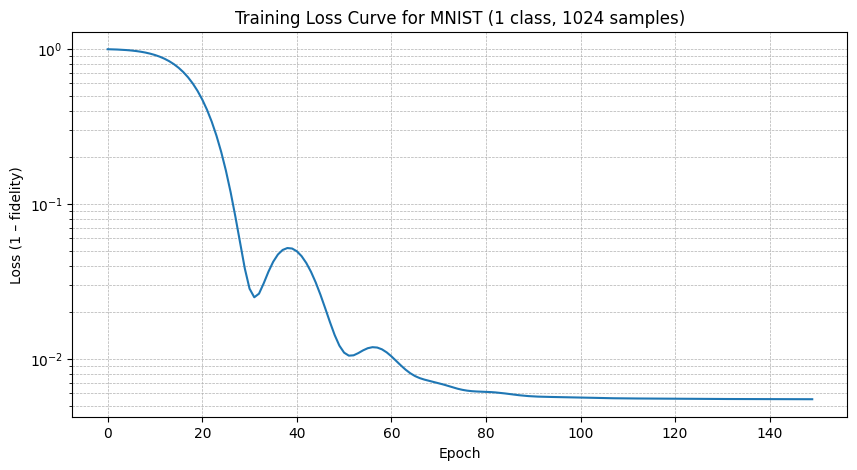

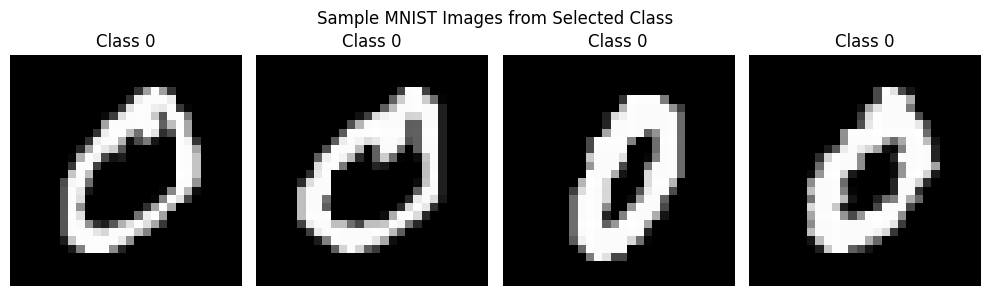

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, 1 class, 1024 samples)
# ───────────────────────────────────────────────────────────
SEED                 = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES         = 256                                # 2^8 amplitudes -> 8 data qubits
NUM_STATES           = 1                                  # Single class
WORK_QUBITS          = int(math.log2(NUM_FEATURES))       # 256 -> 8
ANCILLA_QUBITS       = 0                                  # No ancilla for single class
TOTAL_QUBITS         = WORK_QUBITS                        # 8 total wires
WIRES                = list(range(TOTAL_QUBITS))
BATCH_SIZE           = 1
DEPTH                = 10
LR                   = 5e-3
MAX_EPOCHS           = 150

CLASSES              = [0]                                # choose one class
SAMPLES_PER_CLASS    = 1024

# ───────────────────────────────────────────────────────────
# 2. DATASET
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset (Classes: ", CLASSES, ") ---")

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Collect indices for the single class
selected_indices_by_class = {c: [] for c in CLASSES}
for i, (_, label) in enumerate(mnist_dataset):
    if label in selected_indices_by_class and len(selected_indices_by_class[label]) < SAMPLES_PER_CLASS:
        selected_indices_by_class[label].append(i)
    if all(len(v) >= SAMPLES_PER_CLASS for v in selected_indices_by_class.values()):
        break

# Combine in class order
selected_indices = []
for c in CLASSES:
    assert len(selected_indices_by_class[c]) == SAMPLES_PER_CLASS, f"Not enough samples collected for class {c}"
    selected_indices.extend(selected_indices_by_class[c])

subset_selected = Subset(mnist_dataset, selected_indices)

print("Selection summary:")
for c in CLASSES:
    print(f"  Class {c}: {len(selected_indices_by_class[c])} images")
print(f"Total selected images: {len(subset_selected)}")

# Build feature matrix and class labels
X_list = []
y_list = []
for i in range(len(subset_selected)):
    image, label = subset_selected[i]
    image_flat = image.view(-1).numpy()  # 784
    X_list.append(image_flat)
    y_list.append(label)

X = np.array(X_list)   # (1024, 784)
y = np.array(y_list)   # labels all in {0}

print(f"Original image features shape: {X.shape}")

# Remap labels (trivial for single class)
label_to_state = {c: i for i, c in enumerate(CLASSES)}  # {0:0}
y_mapped = np.array([label_to_state[int(lbl)] for lbl in y])
print("Label mapping:", label_to_state)

# Stage: PCA directly to 256 components (matching 8 qubits)
print(f"--- PCA reduction to {NUM_FEATURES} components ---")
pca_components = min(NUM_FEATURES, X.shape[0], X.shape[1])  # guard
pca = PCA(n_components=pca_components, random_state=SEED)
X_proj = pca.fit_transform(X)  # (1024, 256)

# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Compute mean feature vector for the single class
mean_vec = X_scaled.mean(axis=0, keepdims=True)           # shape: (1, 256)

# Normalize to form valid target quantum state
norms = np.linalg.norm(mean_vec, axis=1, keepdims=True)
Y_targets_np = mean_vec / norms                            # shape: (1, 256)

print("\n--- Target State from MNIST ---")
print(f"Shape of target vector: {Y_targets_np.shape}")
print(f"  Class {CLASSES} norm: {np.linalg.norm(Y_targets_np):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)  # tensor()

# Tiny dataset of 1 class state
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory, no ancilla needed)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis):
    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector (size 2**WORK_QUBITS == 256)
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, batch_size=1):
        ry_thetas, crx_phis = self.get_params()
        # Produce 'batch_size' identical states for batching convenience
        states = [circuit(ry_thetas, crx_phis) for _ in range(batch_size)]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)   # batchwise inner product
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, _ = batch
    full_states = model(batch_size=BATCH_SIZE)  # shape: (B, 256) complex
    # Already only the data subspace; normalize and compare
    preds = full_states / (torch.linalg.norm(full_states, dim=1, keepdim=True) + 1e-12)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST 1-class target) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelity on MNIST Target State ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        full_psi = circuit(ry_thetas, crx_phis)  # shape: (256,)
        norm = torch.linalg.norm(full_psi)
        if norm > 1e-12:
            full_psi = full_psi / norm
        fid = torch.abs(torch.dot(torch.conj(full_psi), Y_targets.squeeze())) ** 2
        print(f"Fidelity for MNIST class {CLASSES}: {fid.item():.6f}")

    print("─────────────────────────")

    # Plotting training curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST (1 class, 1024 samples)")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: visualize a few samples
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 4, figsize=(10, 3))
        for k in range(4):
            img, lbl = subset_selected[k]
            axes[k].imshow(img.squeeze(), cmap='gray')
            axes[k].set_title(f'Class {lbl}')
            axes[k].axis('off')
        plt.suptitle('Sample MNIST Images from Selected Class')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

--- Loading MNIST Dataset A (Classes: [0, 1, 2, 3, 4, 5, 6, 7] ) ---
Selection summary:
  Class 0: 128 images
  Class 1: 128 images
  Class 2: 128 images
  Class 3: 128 images
  Class 4: 128 images
  Class 5: 128 images
  Class 6: 128 images
  Class 7: 128 images
Total selected images: 1024
Original image features shape: (1024, 784)
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}
--- PCA reduction to 256 components ---

--- Target States from MNIST ---
Shape of target vectors: (8, 256)
  Class 0 (state 0) norm: 1.000000
  Class 1 (state 1) norm: 1.000000
  Class 2 (state 2) norm: 1.000000
  Class 3 (state 3) norm: 1.000000
  Class 4 (state 4) norm: 1.000000
  Class 5 (state 5) norm: 1.000000
  Class 6 (state 6) norm: 1.000000
  Class 7 (state 7) norm: 1.000000
-----------------------------------------
Using device: default.qubit with 11 wires.

--- Starting Training (MNIST 4-class targets) ---


/usr/local/lib/python3.12/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.997963 | LR 0.005000
Epoch   20 | Avg Loss 0.041993 | LR 0.005000
Epoch   40 | Avg Loss 0.008282 | LR 0.005000
Epoch   60 | Avg Loss 0.007803 | LR 0.005000
Epoch   80 | Avg Loss 0.007779 | LR 0.005000
Epoch  100 | Avg Loss 0.007779 | LR 0.005000
Epoch  120 | Avg Loss 0.007755 | LR 0.002500
Epoch  140 | Avg Loss 0.007748 | LR 0.002500
--- Training Complete ---

Training wall-time: 12872.7s

── Final Model Fidelities on MNIST Target States ──
Fidelity for MNIST class 0 (state 0): 0.992743
Fidelity for MNIST class 1 (state 1): 0.991115
Fidelity for MNIST class 2 (state 2): 0.992965
Fidelity for MNIST class 3 (state 3): 0.992667
Fidelity for MNIST class 4 (state 4): 0.991921
Fidelity for MNIST class 5 (state 5): 0.992831
Fidelity for MNIST class 6 (state 6): 0.992080
Fidelity for MNIST class 7 (state 7): 0.991718
─────────────────────────
Average fidelity: 0.992255
Minimum fidelity: 0.991115


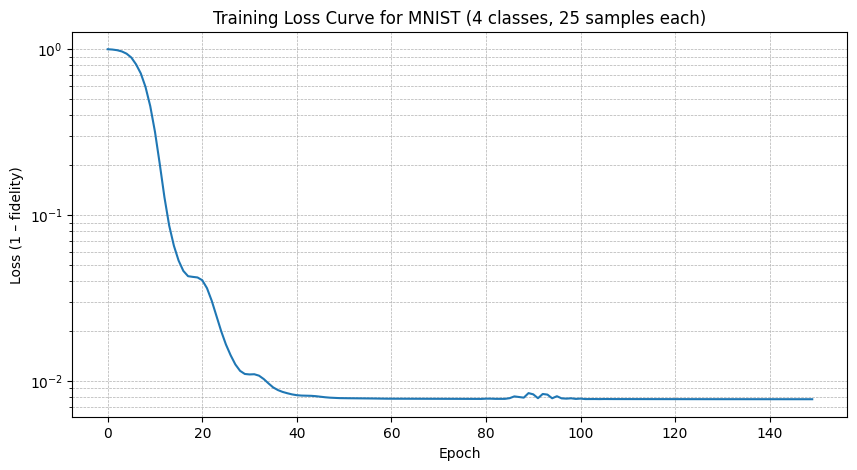

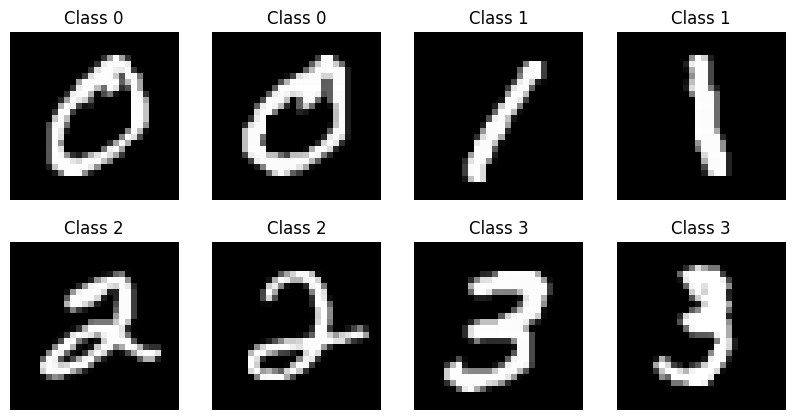

In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, 4 classes, 25 samples each)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 8                                 # Four classes
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = math.ceil(math.log2(NUM_STATES))  # 4 -> 2 ancilla qubits
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 10 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 4
DEPTH               = 12
LR                  = 5e-3
MAX_EPOCHS          = 150

CLASSES             = [0, 1, 2, 3, 4 ,5, 6, 7]                      # Choose any 4 classes from 0..9
SAMPLES_PER_CLASS   = 128

# ───────────────────────────────────────────────────────────
# 2. DATASET (MNIST with 25 images each of 4 classes)
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset A (Classes:", CLASSES, ") ---")

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Collect indices for each target class
selected_indices_by_class = {c: [] for c in CLASSES}
for i, (_, label) in enumerate(mnist_dataset):
    if label in selected_indices_by_class and len(selected_indices_by_class[label]) < SAMPLES_PER_CLASS:
        selected_indices_by_class[label].append(i)
    if all(len(v) >= SAMPLES_PER_CLASS for v in selected_indices_by_class.values()):
        break

# Combine in the order of CLASSES
selected_indices = []
for c in CLASSES:
    assert len(selected_indices_by_class[c]) == SAMPLES_PER_CLASS, f"Not enough samples for class {c}"
    selected_indices.extend(selected_indices_by_class[c])

subset_selected = Subset(mnist_dataset, selected_indices)

print("Selection summary:")
for c in CLASSES:
    print(f"  Class {c}: {len(selected_indices_by_class[c])} images")
print(f"Total selected images: {len(subset_selected)}")

# Build feature matrix X and labels y
X_list, y_list = [], []
for i in range(len(subset_selected)):
    image, label = subset_selected[i]
    image_flat = image.view(-1).numpy()  # 784 vector
    X_list.append(image_flat)
    y_list.append(label)

X = np.array(X_list)  # Shape: (100, 784)
y = np.array(y_list)

print(f"Original image features shape: {X.shape}")

# Remap labels to contiguous states {0,1,2,3} according to CLASSES order
label_to_state = {c: i for i, c in enumerate(CLASSES)}
y_mapped = np.array([label_to_state[int(lbl)] for lbl in y])
print("Label mapping:", label_to_state)

# Stage 1: PCA directly to 256 components (matching 8 qubits)
print(f"--- PCA reduction to {NUM_FEATURES} components ---")
pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_proj = pca.fit_transform(X)  # shape


# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Compute mean feature vector for each mapped class
mean_vectors = []
for state_idx in range(NUM_STATES):
    mean_vec = X_scaled[y_mapped == state_idx].mean(axis=0)
    mean_vectors.append(mean_vec)
mean_vectors = np.array(mean_vectors)  # shape: (4, 256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from MNIST ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
for i, c in enumerate(CLASSES):
    print(f"  Class {c} (state {i}) norm: {np.linalg.norm(Y_targets_np[i]):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)

# Tiny dataset of 4 class states
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as binary basis state
    binary_state = [(state_idx >> i) & 1 for i in range(ANCILLA_QUBITS)]
    qml.BasisState(binary_state, wires=range(ANCILLA_QUBITS))

    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST 4-class targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on MNIST Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            mapped_label = CLASSES[i]
            print(f"Fidelity for MNIST class {mapped_label} (state {i}): {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting training curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST (4 classes, 25 samples each)")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: visualize a few samples per class (8 images total)
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 4, figsize=(10, 5))
        idx = 0
        for ci, c in enumerate(CLASSES):
            # show two samples from each class
            for k in range(2):
                img, lbl = subset_selected[ci*SAMPLES_PER_CLASS + k]
                axes[idx // 4, idx % 4].imshow(img.squeeze(), cmap='gray')
                axes[idx // 4, idx % 4].set_title(f'Class {lbl}')
                axes[idx // 4, idx % 4].axis('off')
                idx += 1
        plt.suptitle('Sample MNIST Images from Selected Classes')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass
